# Combining it all

Here we will combine the approaches of all the past inversions. Here our the main steps we will follow:

1) create a true topography and synthetic observed gravity
2) create a starting model from the points of known topography (`constraints`) 
3) calculate a starting misfit
4) perform a damping parameter cross validation to determine the optimal damping value
5) use this damping value to perform an optimization to find the optimal density and reference level values
6) create the weighting grid to help the inversion adhere to the constraints
7) perform a full final inversion constrained by the `weighting grid`, using the optimal damping, density, and reference level values. 


## Import packages

In [1]:
import pathlib
import pickle

import numpy as np
import pandas as pd
import polartoolkit as ptk
import verde as vd
import xarray as xr

import invert4geom

/home/mdtanker/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Get Input datasets

In [2]:
true_topography, _, _, _ = invert4geom.load_synthetic_model(
    spacing=1000,
    region=(0, 40000, 0, 30000),
)

# create lower synthetic topography data
lower_topography = invert4geom.synthetic_topography_regional(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    scale=1,
    yoffset=-1000,
)

true_zref = true_topography.to_numpy().mean()
true_density_contrast = 2670 - 1  # sea level
print(f"mean of true topography: {true_zref} m ")

mean of true topography: 492.2704164812973 m 


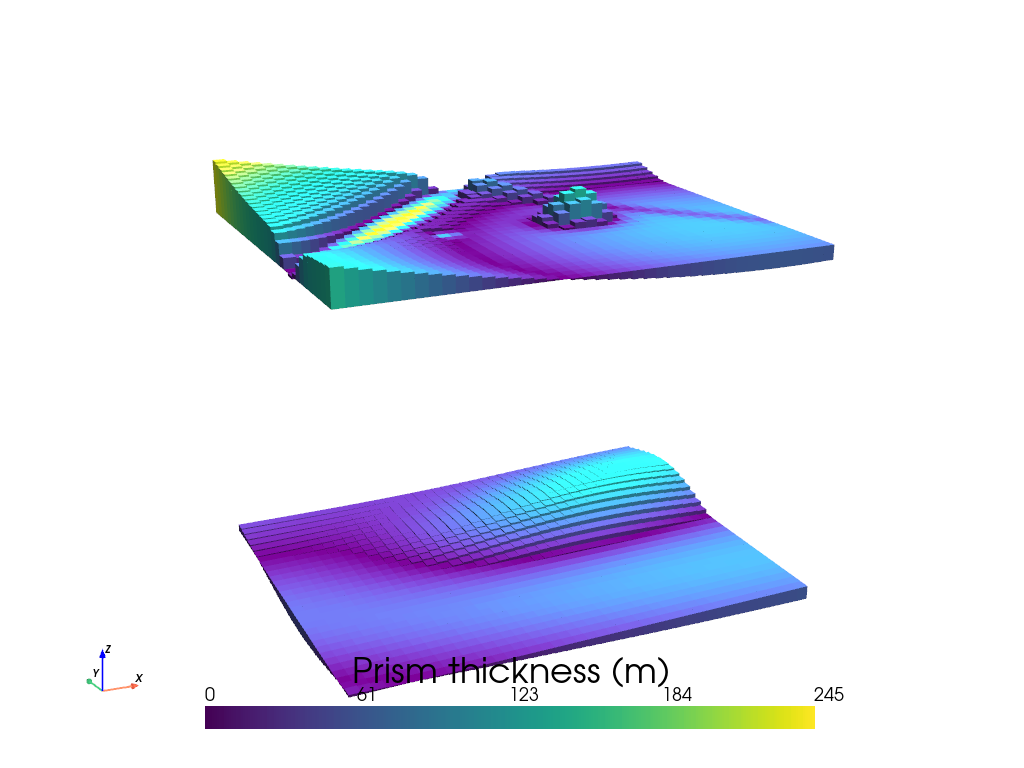

In [3]:
topography_model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    topography=true_topography.to_dataset(name="upward"),
)
basement_model = invert4geom.create_model(
    zref=lower_topography.to_numpy().mean(),
    density_contrast=3300 - 2800,
    topography=lower_topography.to_dataset(name="upward"),
)

invert4geom.plot_prism_layers(
    [topography_model, basement_model],
    color_by="thickness",
    zscale=20,
)

In [4]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey

# create an inside region to reduce gravity edge effects
# region = vd.pad_region(topography_model.region, topography_model.spacing * -5)

# create lists of coordinates
coords = vd.grid_coordinates(
    region=topography_model.region,
    spacing=topography_model.spacing,
    pixel_register=False,
    extra_coords=1001,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

# grav_df = vd.grid_to_table(observations)

In [5]:
data = invert4geom.create_data(observations)

print(f"Gravity region (W,E,S,N): {data.region}")
print(f"Gravity spacing: {data.spacing} m")

data

Gravity region (W,E,S,N): (0.0, 40000.0, 0.0, 30000.0)
Gravity spacing: 1000.0 m


<xarray.Dataset> Size: 11kB
Dimensions:   (northing: 31, easting: 41)
Coordinates:
  * easting   (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04
  * northing  (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04
Data variables:
    upward    (northing, easting) float64 10kB 1.001e+03 1.001e+03 ... 1.001e+03
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

In [6]:
data.inv.forward_gravity(topography_model, name="upper_surface_grav")
data.inv.forward_gravity(basement_model, name="lower_surface_grav")
data.inv.df.describe()

,northing,easting,upward,upper_surface_grav,lower_surface_grav
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.129619,0.004659
std,8947.792584,11836.81698,0.0,7.147140,0.830306
min,0.000000,0.00000,1001.0,-17.180401,-1.201774
25%,7000.000000,10000.00000,1001.0,-5.537833,-0.699901
50%,15000.000000,20000.00000,1001.0,-1.136301,-0.177953
75%,23000.000000,30000.00000,1001.0,3.743994,0.629891
max,30000.000000,40000.00000,1001.0,19.581120,1.860259


In [7]:
# contaminate gravity with 0.1 mGal of random noise
data["gravity_anomaly_no_noise"] = data.upper_surface_grav + data.lower_surface_grav
data["gravity_anomaly"], stddev = invert4geom.contaminate(
    data.gravity_anomaly_no_noise,
    stddev=0.1,
    percent=False,
    seed=0,
)
data["uncert"] = xr.full_like(data.gravity_anomaly, stddev)
data

<xarray.Dataset> Size: 62kB
Dimensions:                   (northing: 31, easting: 41)
Coordinates:
  * easting                   (easting) float64 328B 0.0 1e+03 ... 3.9e+04 4e+04
  * northing                  (northing) float64 248B 0.0 1e+03 ... 3e+04
Data variables:
    upward                    (northing, easting) float64 10kB 1.001e+03 ... ...
    upper_surface_grav        (northing, easting) float64 10kB 9.526 ... 2.855
    lower_surface_grav        (northing, easting) float64 10kB -0.04793 ... 0...
    gravity_anomaly_no_noise  (northing, easting) float64 10kB 9.478 ... 3.368
    gravity_anomaly           (northing, easting) float64 10kB 9.495 ... 3.425
    uncert                    (northing, easting) float64 10kB 0.1 0.1 ... 0.1
Attributes:
    region:        (0.0, 40000.0, 0.0, 30000.0)
    spacing:       1000.0
    buffer_width:  3000.0
    inner_region:  (3000.0, 37000.0, 3000.0, 27000.0)
    dataset_type:  data
    model_type:    prisms

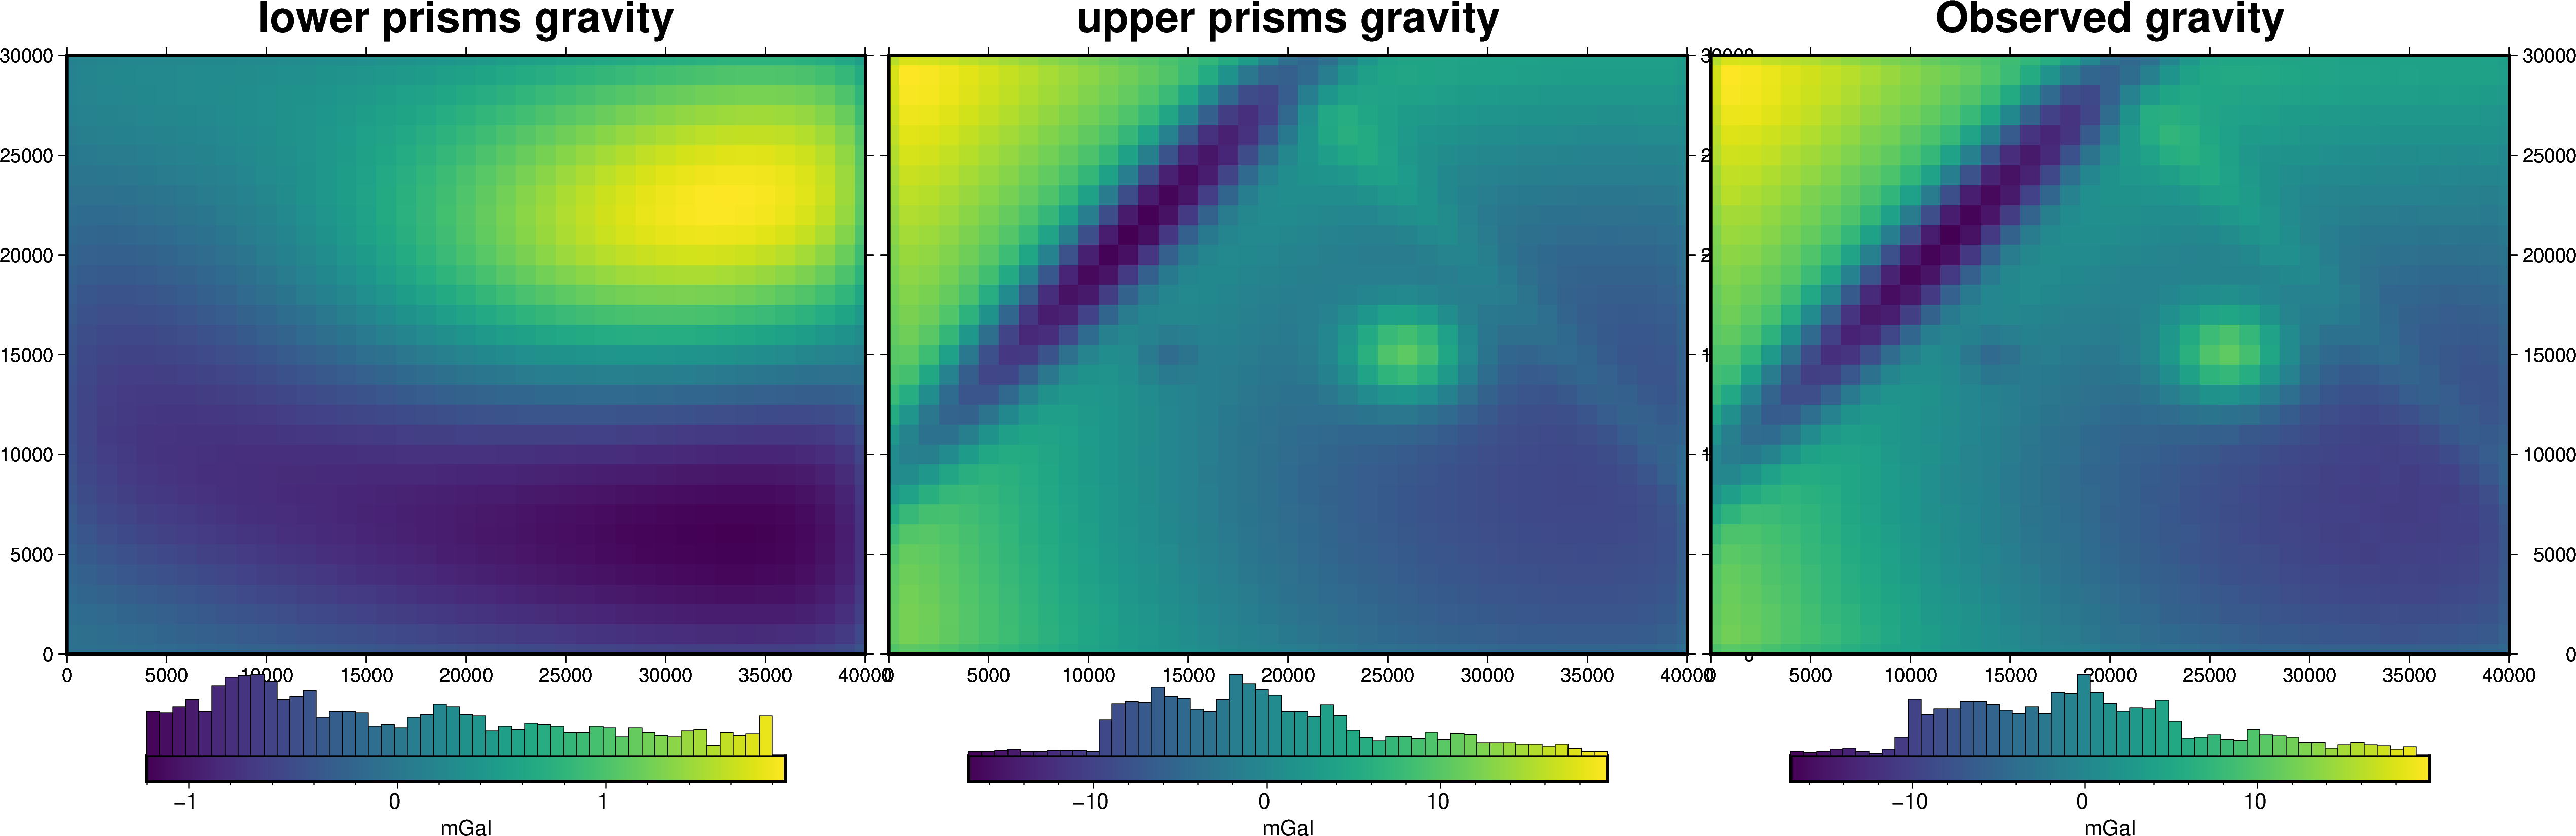

In [8]:
fig = ptk.plot_grid(
    data.lower_surface_grav,
    fig_height=10,
    title="lower prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = ptk.plot_grid(
    data.upper_surface_grav,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="upper prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = ptk.plot_grid(
    data.gravity_anomaly,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## Create "a-priori" topography measurements

In [9]:
# create 15 random point within the outcropping basement region
num_constraints = 15
coords = vd.scatter_points(
    region=vd.pad_region(data.region, -data.spacing),
    size=num_constraints,
    random_state=7,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    true_topography,
    "true_upward",
)

constraint_points["upward"] = constraint_points.true_upward

# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 2% of depth
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points = invert4geom.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.uncert**2)

constraint_points.head()

,easting,northing,true_upward,upward,uncert,weight
0,3899.714996,26468.618776,655.102400,656.749723,13.102048,0.005825
1,30636.914105,6974.789900,407.011208,405.935844,8.140224,0.015091
2,17659.550795,13659.470931,470.155613,476.177579,9.403112,0.011310
3,28491.676758,27073.768551,515.239653,516.320627,10.304793,0.009417
4,38163.601456,1697.178371,419.197817,414.706788,8.383956,0.014227


## Create starting model

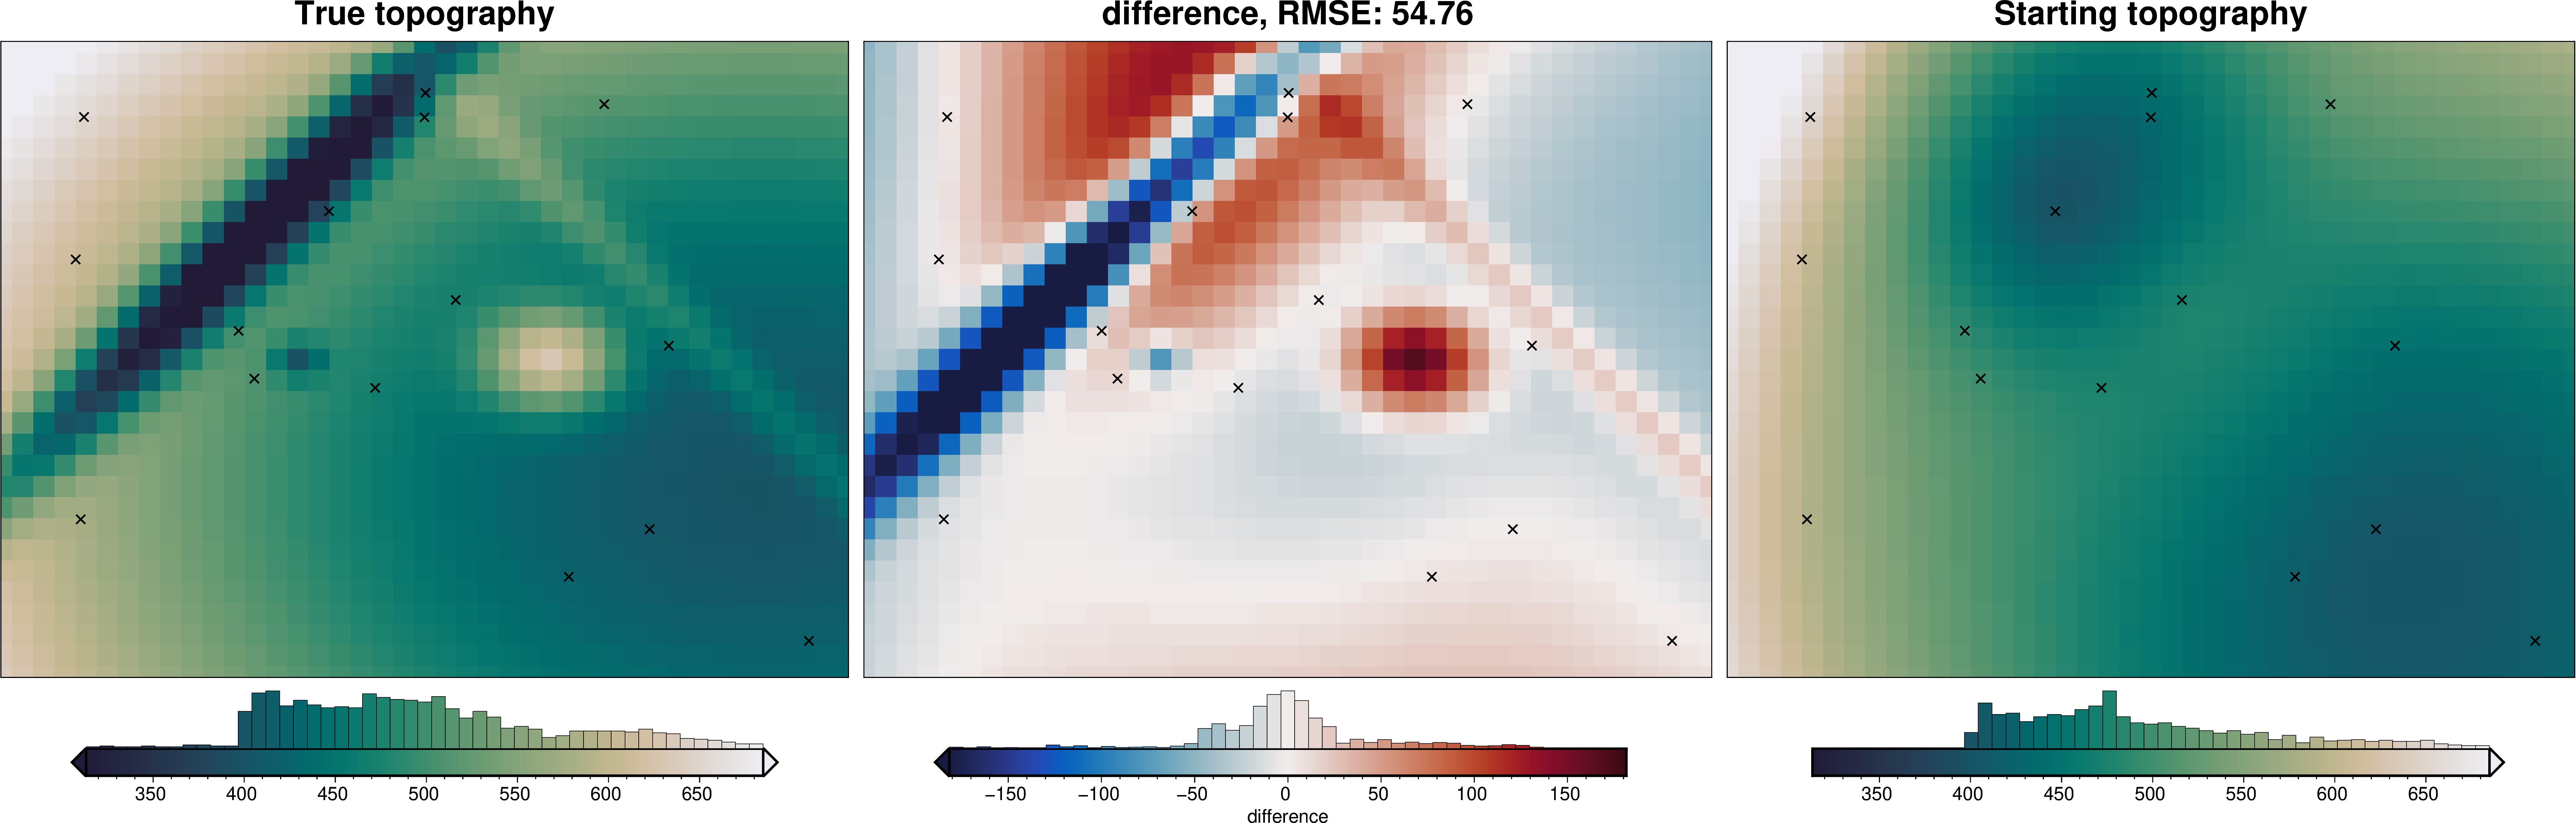

In [10]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=topography_model.region,
    spacing=topography_model.spacing,
    constraints_df=constraint_points,
    dampings=np.logspace(-40, 0, 100),
    weights_col="weight",
)

starting_topography = invert4geom.create_topography(**starting_topography_kwargs)

_ = ptk.grid_compare(
    true_topography,
    starting_topography.upward,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

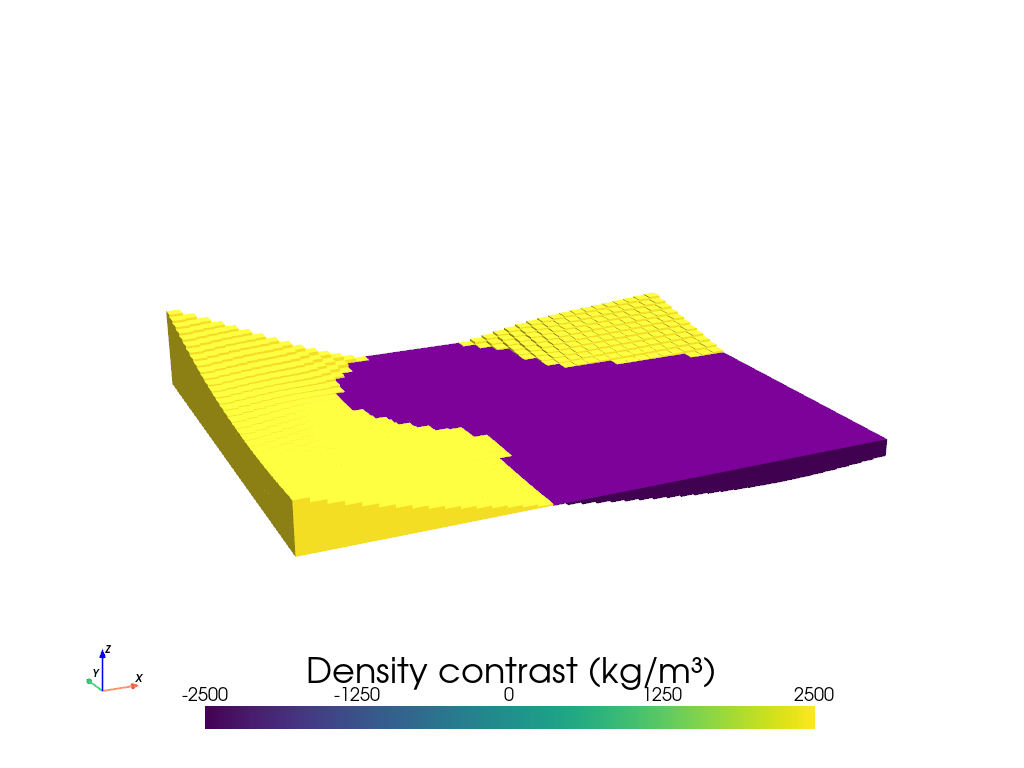

In [11]:
model = invert4geom.create_model(
    zref=constraint_points.upward.mean(),
    density_contrast=2500,
    topography=starting_topography,
)
model.inv.plot_model(
    color_by="density",
    zscale=20,
)

## Calculate starting gravity misfit 
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

We don't know the optimal values for the density contrast or the reference level, so we will make a guess at appropriate values for the starting model.

In [12]:
data.inv.forward_gravity(model)

# calculate the true residual misfit
# true misfit is difference between noise-free gravity and starting gravity
# true regional misfit is the moho gravity
# so true residual is misfit - true_regional
data["true_res"] = (
    data.gravity_anomaly_no_noise - data.forward_gravity - data.lower_surface_grav
)
data.inv.df.describe()

,northing,easting,upward,upper_surface_grav,lower_surface_grav,gravity_anomaly_no_noise,gravity_anomaly,uncert,forward_gravity,true_res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1.271000e+03,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.129619,0.004659,-0.124959,-0.124959,1.000000e-01,1.079930,-1.209548
std,8947.792584,11836.81698,0.0,7.147140,0.830306,7.314752,7.313577,2.776650e-17,6.599125,4.456801
min,0.000000,0.00000,1001.0,-17.180401,-1.201774,-16.908338,-17.061563,1.000000e-01,-7.883841,-19.046853
25%,7000.000000,10000.00000,1001.0,-5.537833,-0.699901,-5.826630,-5.827131,1.000000e-01,-3.944309,-2.622186
50%,15000.000000,20000.00000,1001.0,-1.136301,-0.177953,-0.557795,-0.572175,1.000000e-01,-0.765707,-1.088926
75%,23000.000000,30000.00000,1001.0,3.743994,0.629891,4.171648,4.139840,1.000000e-01,4.823461,0.332004
max,30000.000000,40000.00000,1001.0,19.581120,1.860259,19.774399,19.944612,1.000000e-01,22.159800,12.693226


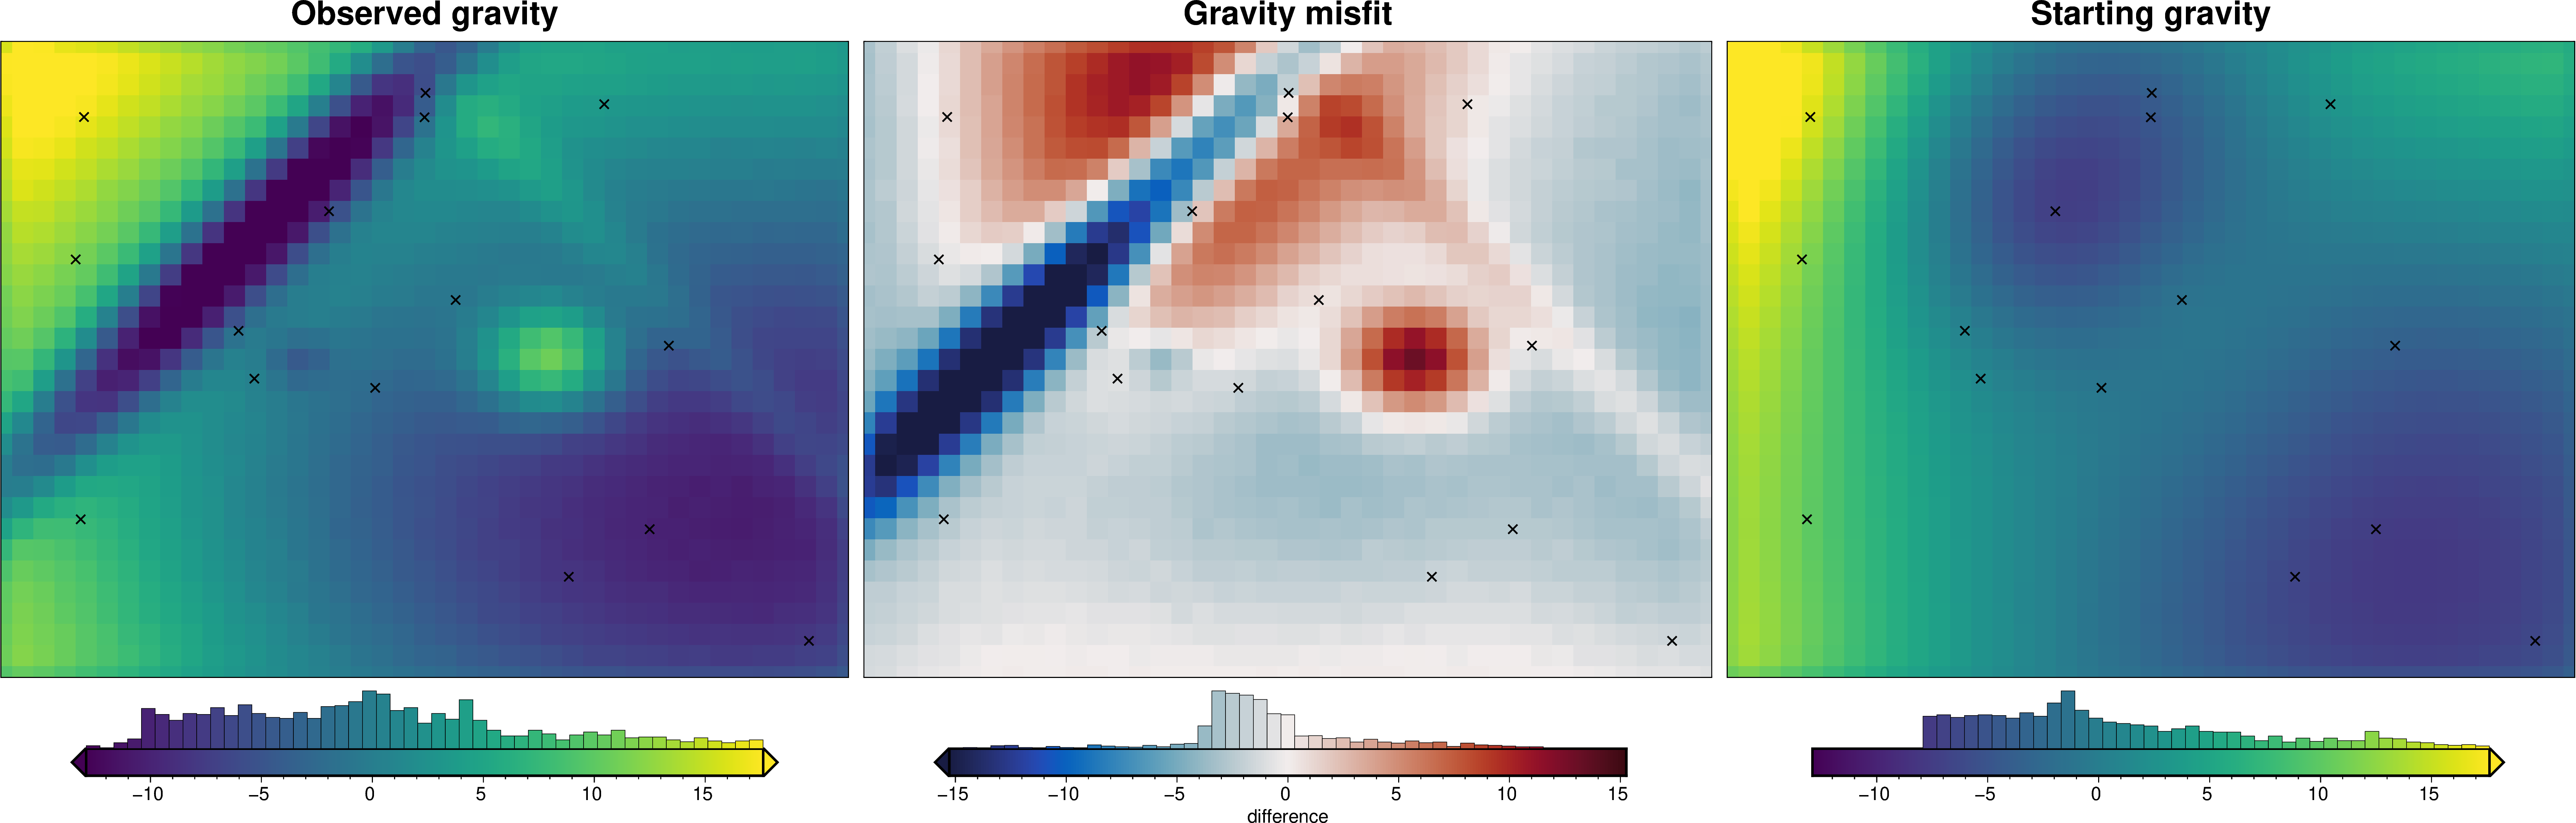

In [13]:
_ = ptk.grid_compare(
    data.gravity_anomaly,
    data.forward_gravity,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    title="Gravity misfit",
    rmse_in_title=False,
    points=constraint_points,
    points_style="x.3c",
)

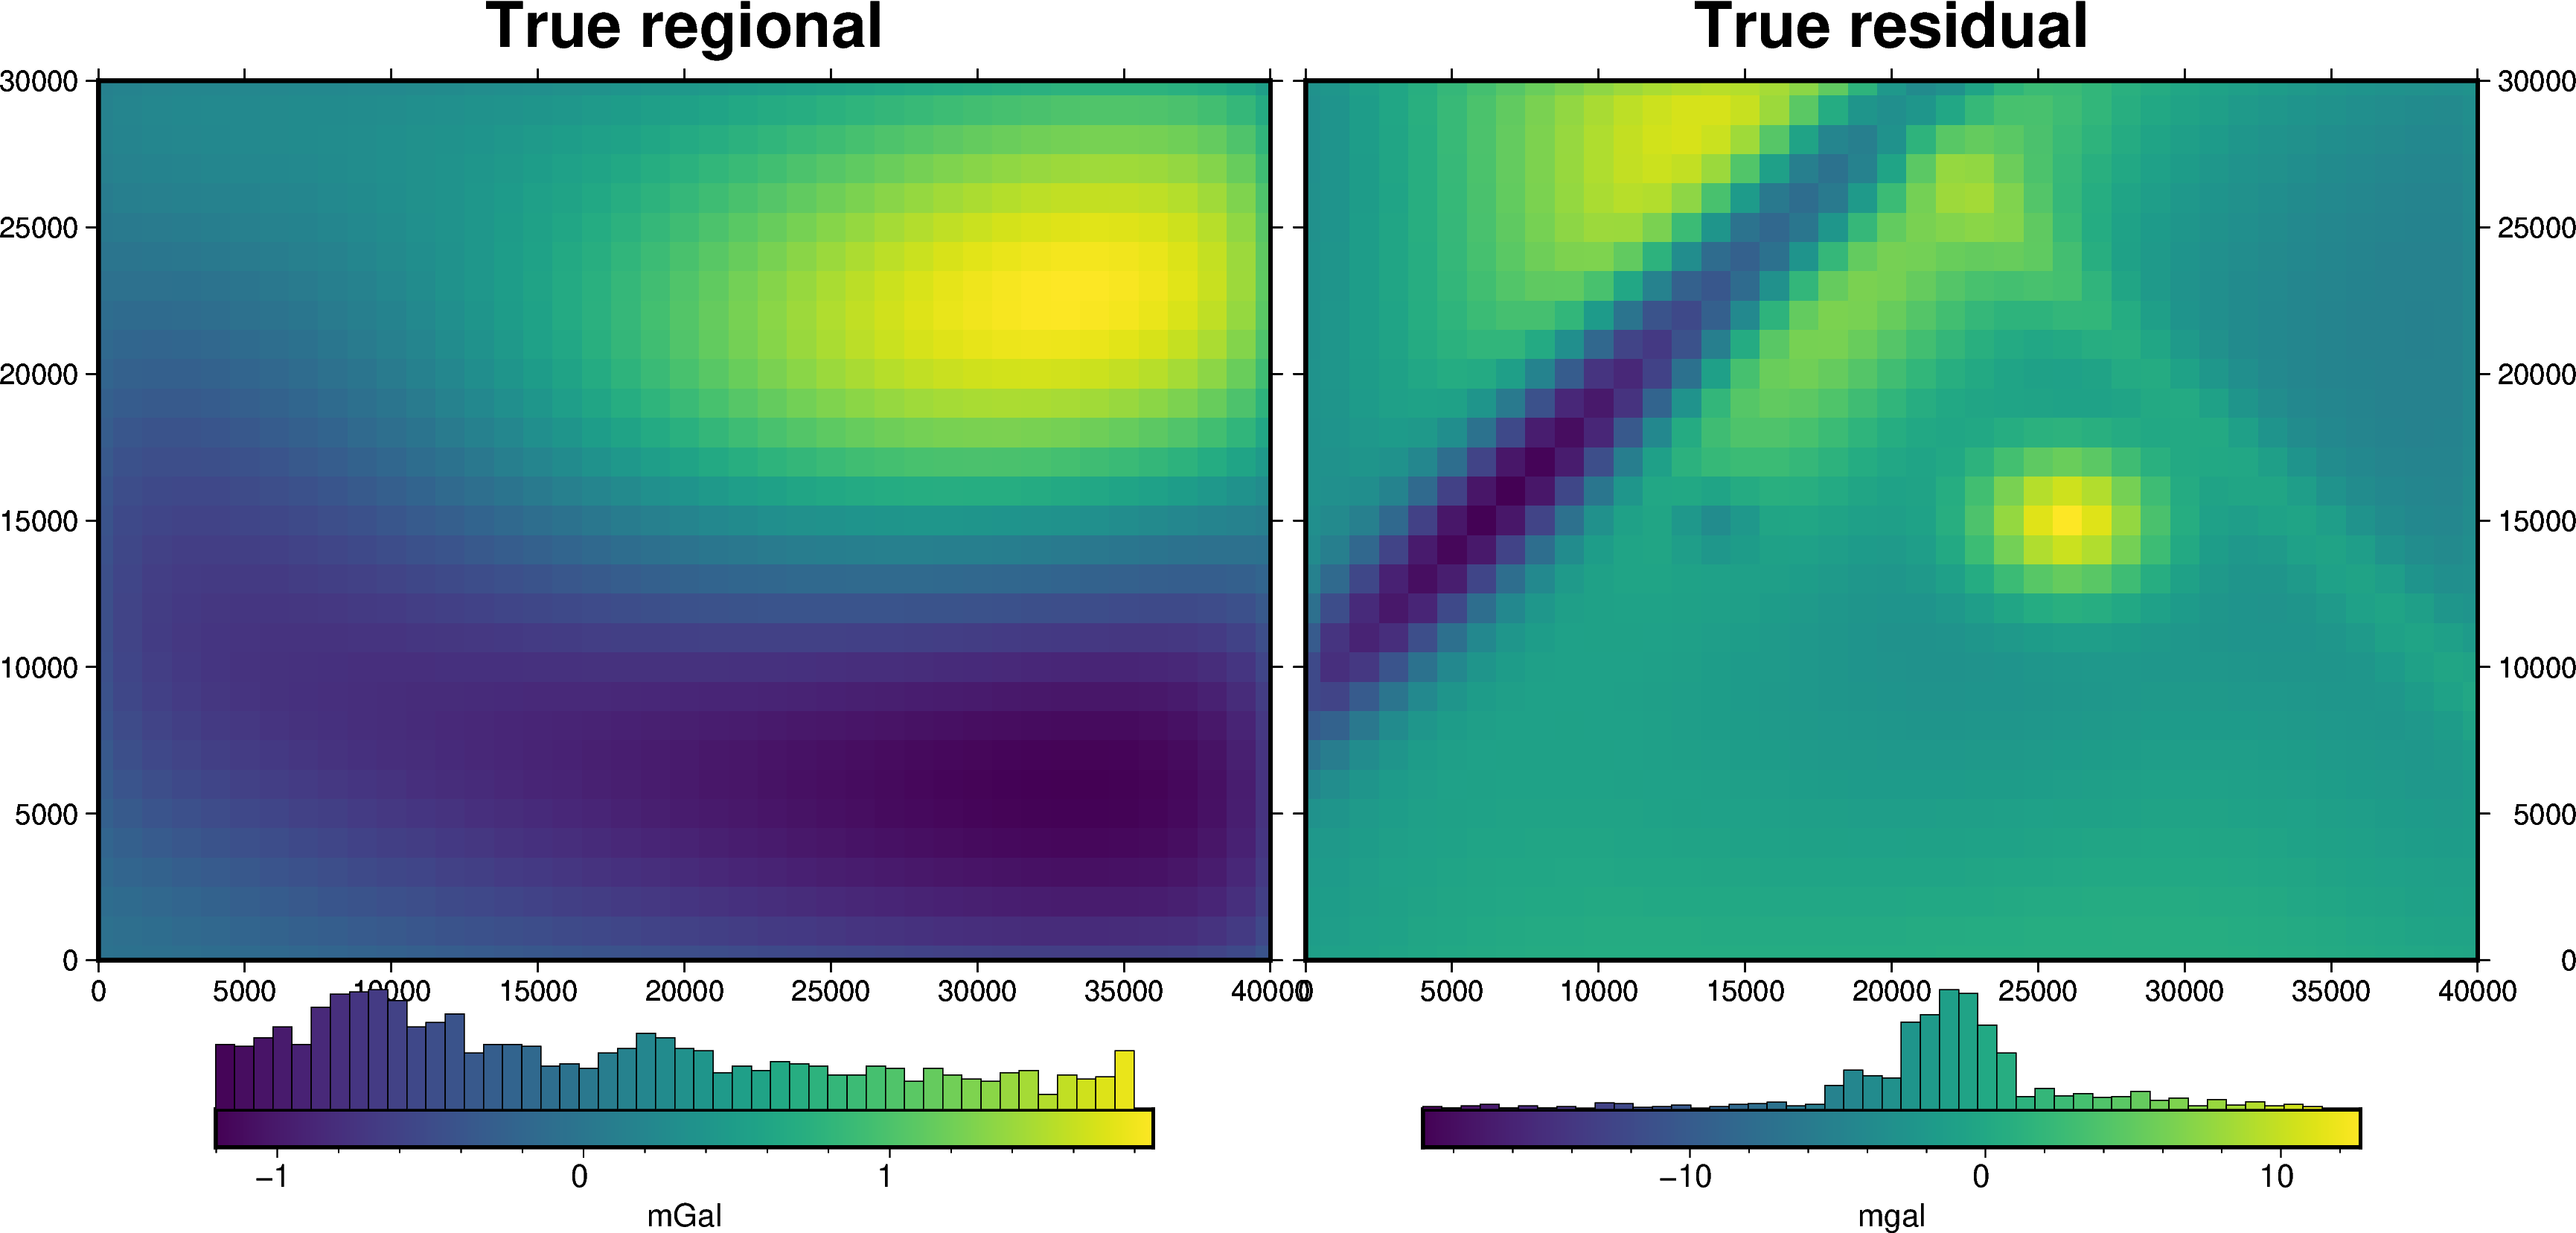

In [14]:
fig = ptk.plot_grid(
    data.lower_surface_grav,
    fig_height=10,
    title="True regional",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = ptk.plot_grid(
    data.true_res,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="True residual",
    hist=True,
    cbar_label="mgal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## Regional separation

In [15]:
def regional_comparison(data):
    # compare with true regional
    _ = ptk.grid_compare(
        data.lower_surface_grav,
        data.reg,
        robust=True,
        grid1_name="True regional field",
        grid2_name="Estimated regional field",
        hist=True,
        inset=False,
        title="difference",
        points=constraint_points,
        points_style="x.3c",
    )
    # compare with true residual
    _ = ptk.grid_compare(
        data.true_res,
        data.res,
        robust=True,
        grid1_name="True residual field",
        grid2_name="Estimated residual field",
        hist=True,
        inset=False,
        title="difference",
        points=constraint_points,
        points_style="x.3c",
    )

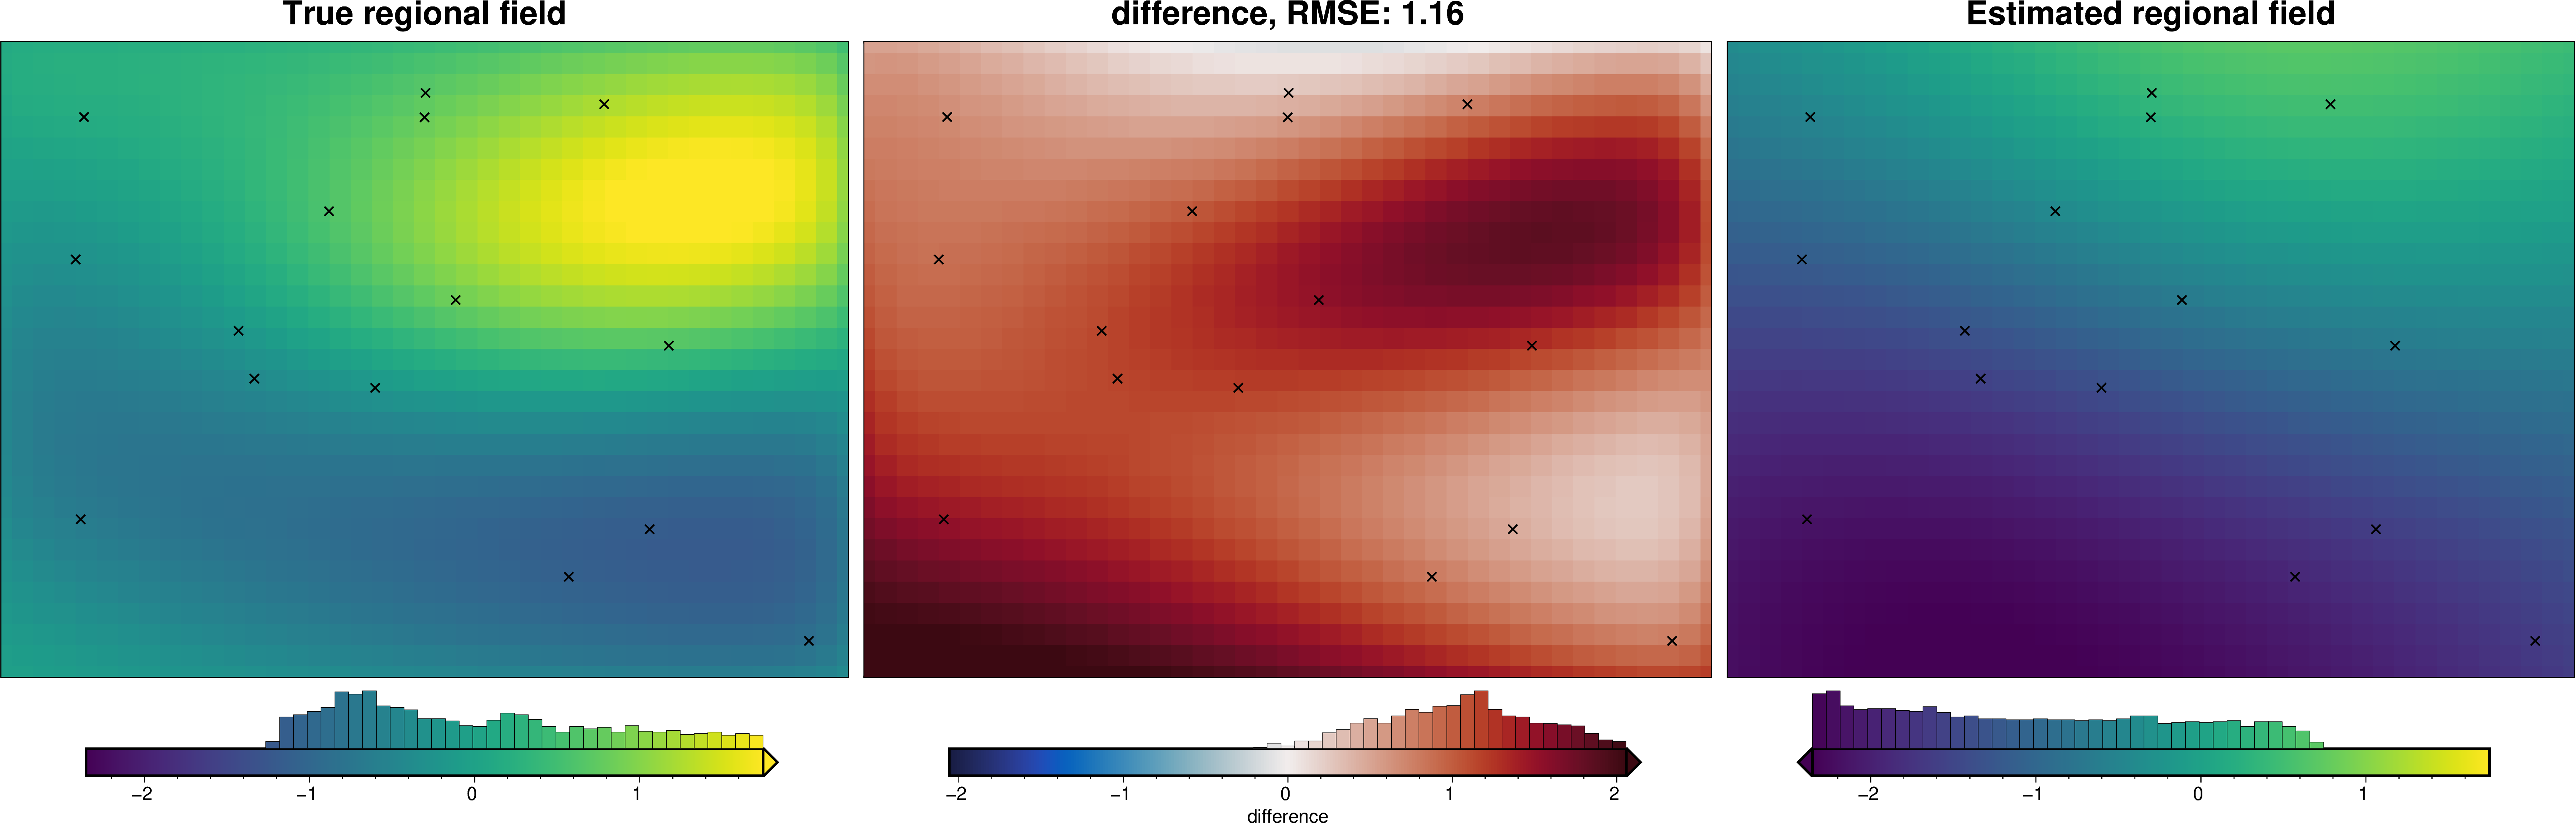

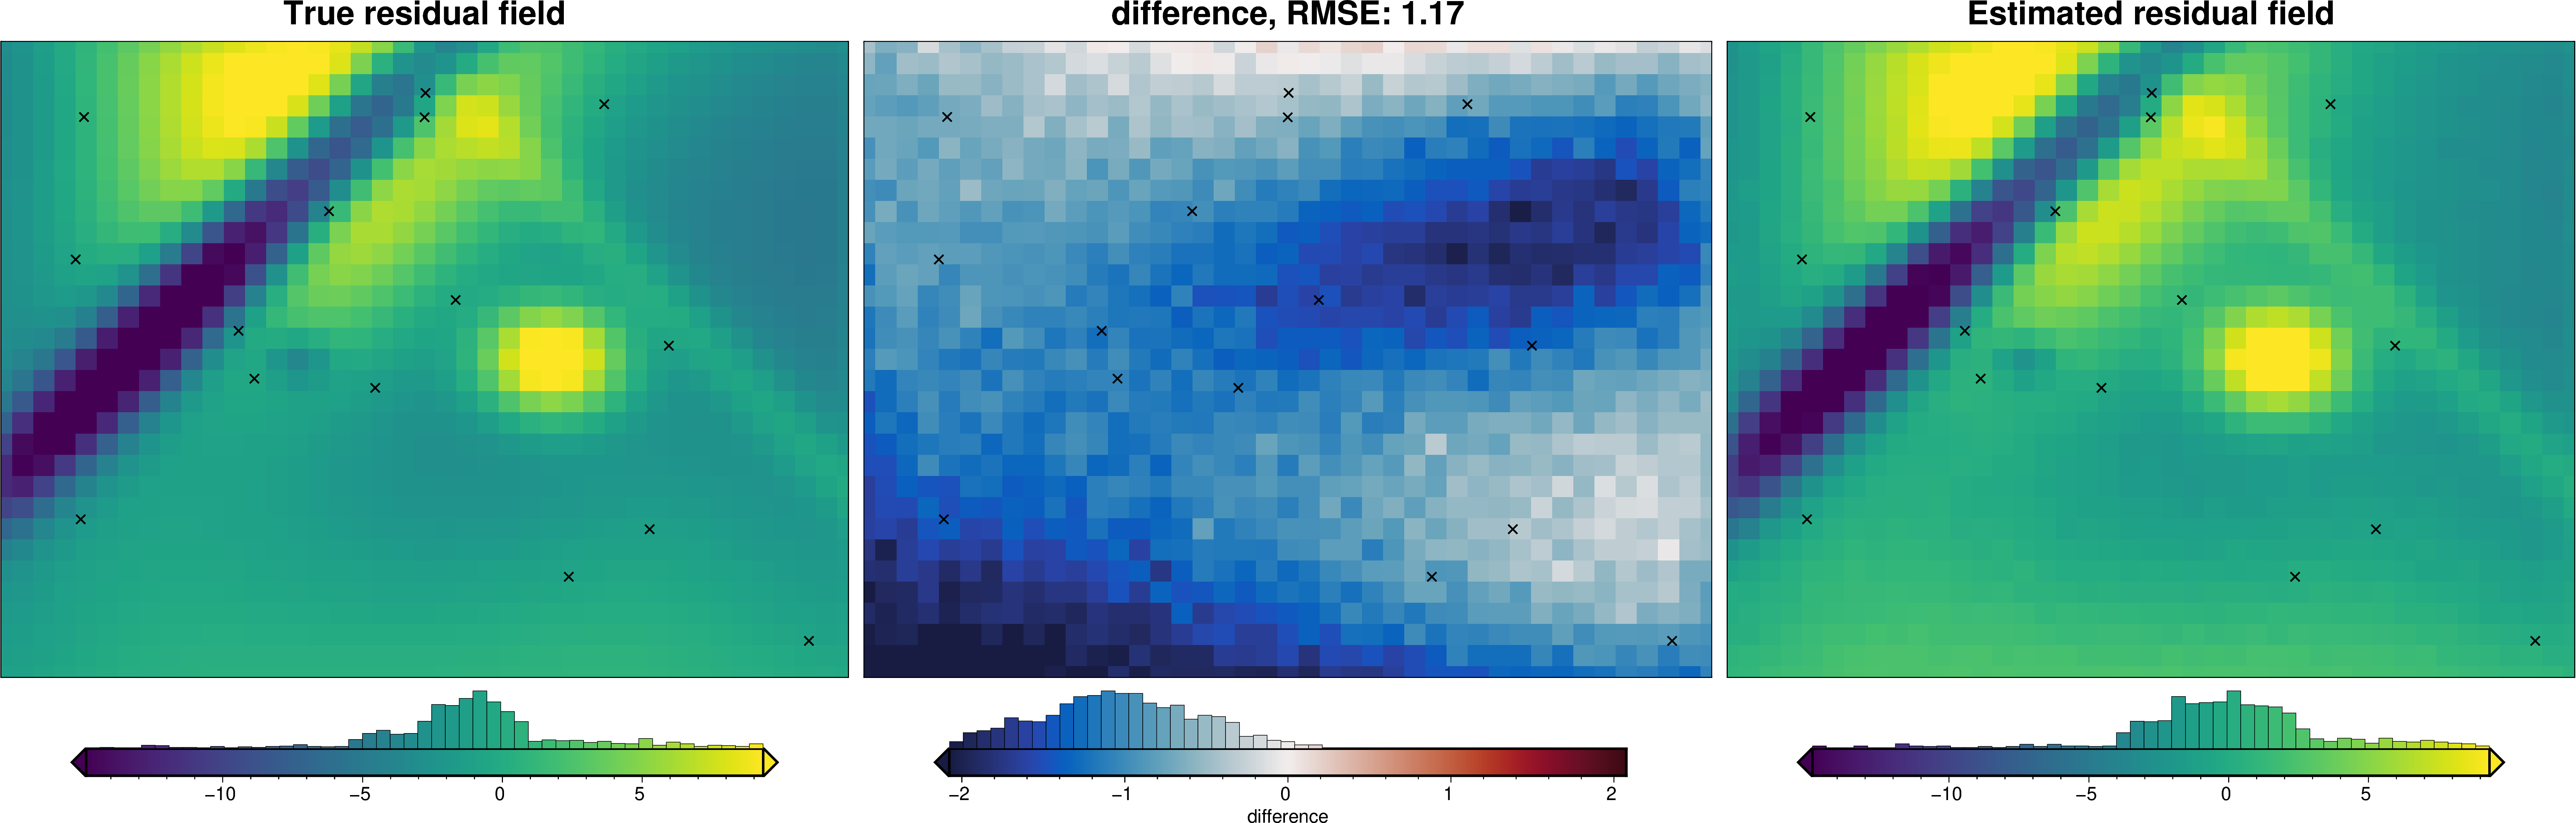

,northing,easting,upward,upper_surface_grav,lower_surface_grav,gravity_anomaly_no_noise,gravity_anomaly,uncert,forward_gravity,true_res,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1.271000e+03,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.129619,0.004659,-0.124959,-0.124959,1.000000e-01,1.079930,-1.209548,-1.204889,-1.050415,-0.154474,1.079930,-1.204889,-1.050415,-0.154474
std,8947.792584,11836.81698,0.0,7.147140,0.830306,7.314752,7.313577,2.776650e-17,6.599125,4.456801,4.644997,0.899573,4.423053,6.599125,4.644997,0.899573,4.423053
min,0.000000,0.00000,1001.0,-17.180401,-1.201774,-16.908338,-17.061563,1.000000e-01,-7.883841,-19.046853,-19.654062,-2.393213,-18.180458,-7.883841,-19.654062,-2.393213,-18.180458
25%,7000.000000,10000.00000,1001.0,-5.537833,-0.699901,-5.826630,-5.827131,1.000000e-01,-3.944309,-2.622186,-2.931387,-1.856053,-1.828949,-3.944309,-2.931387,-1.856053,-1.828949
50%,15000.000000,20000.00000,1001.0,-1.136301,-0.177953,-0.557795,-0.572175,1.000000e-01,-0.765707,-1.088926,-1.578812,-1.142942,-0.050462,-0.765707,-1.578812,-1.142942,-0.050462
75%,23000.000000,30000.00000,1001.0,3.743994,0.629891,4.171648,4.139840,1.000000e-01,4.823461,0.332004,0.296782,-0.286967,1.744250,4.823461,0.296782,-0.286967,1.744250
max,30000.000000,40000.00000,1001.0,19.581120,1.860259,19.774399,19.944612,1.000000e-01,22.159800,12.693226,13.114356,0.688924,14.012415,22.159800,13.114356,0.688924,14.012415


In [16]:
# estimate regional with the mean misfit at constraints
regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_weights_column="weight",
    constraints_df=constraint_points,
    cv=True,
    cv_kwargs=dict(
        n_trials=50,
        damping_limits=(1e-10, 1),
        # depth_limits=(1e3,100e3),
        progressbar=False,
        fname="../tmp/08_combining_it_all_regional_sep",
        # plot=True,
    ),
    depth="default",
    block_size=None,
)

data.inv.regional_separation(
    **regional_grav_kwargs,
)

regional_comparison(data)
data.inv.df.describe()

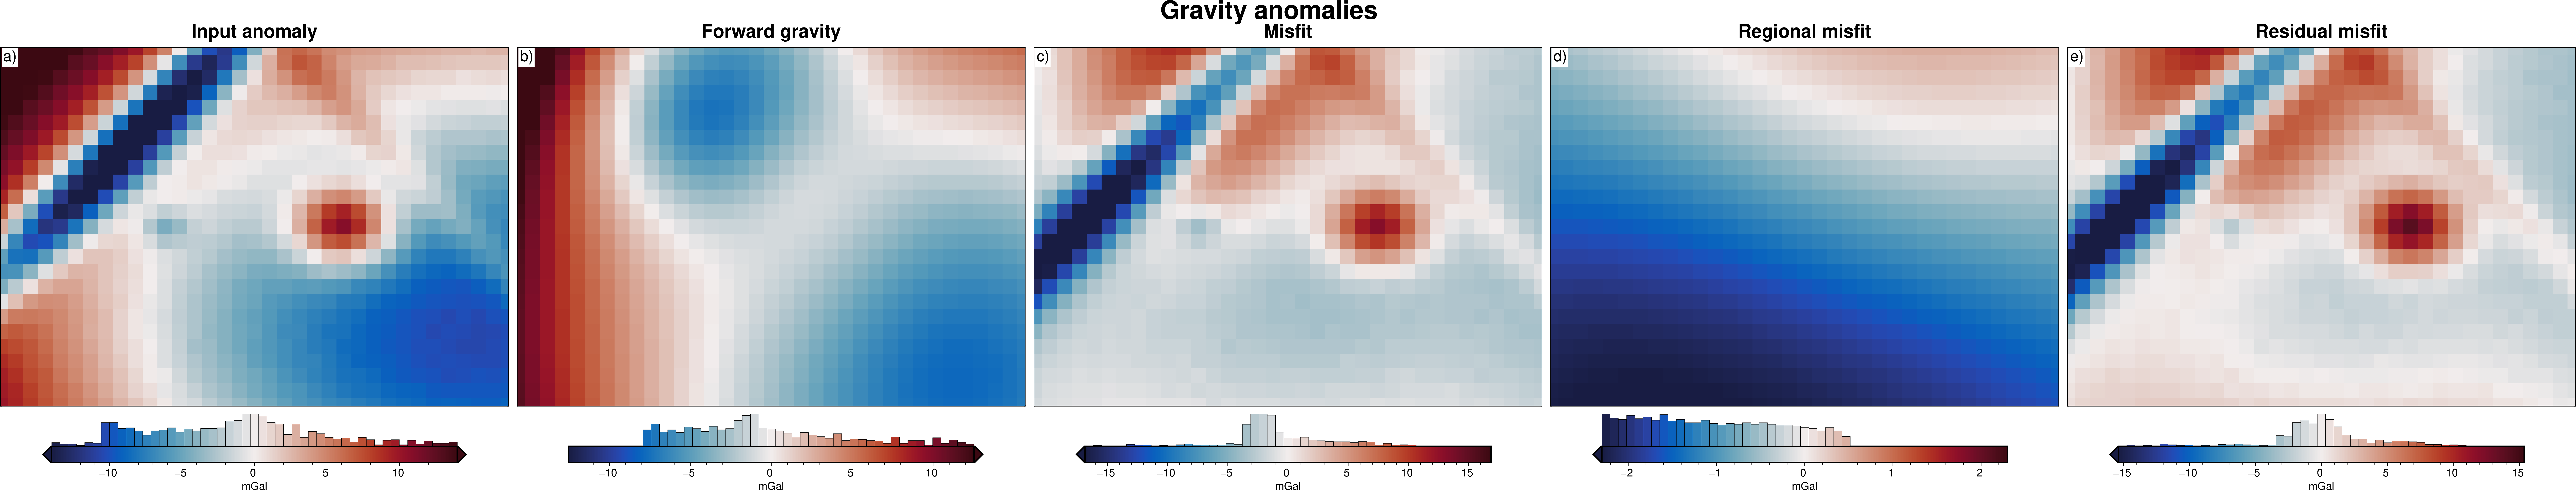

In [17]:
data.inv.plot_anomalies()

## Single inversion
Perform a single inversion to experiment with values of stopping criteria.

In [18]:
# setup the inversion
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.005,
    # set stopping criteria
    l2_norm_tolerance=0.3,  # grav error of .1mGal -> sqrt(.1) = 0.3
    delta_l2_norm_tolerance=1.008,
)

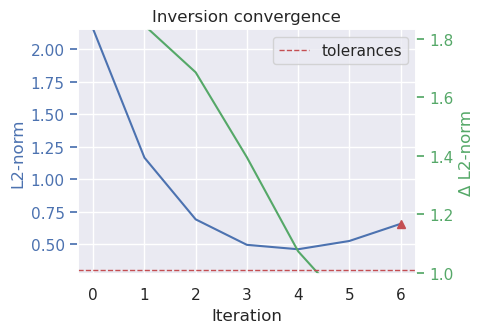

In [19]:
# run the inversion
inv.invert(
    plot_dynamic_convergence=True,
    results_fname="../tmp/08_combining_it_all",
)

In [20]:
inv.stats_df

,iteration,rmse,l2_norm,delta_l2_norm,iter_time_sec
0,0.0,4.636110,2.153163,inf,NaN
1,1.0,1.360590,1.166443,1.845921,0.940450
2,2.0,0.478948,0.692061,1.685464,0.189990
3,3.0,0.246155,0.496140,1.394891,0.167846
4,4.0,0.213645,0.462218,1.073390,0.240549
5,5.0,0.276411,0.525748,0.879163,0.232575
6,6.0,0.432150,0.657382,0.799760,0.196875


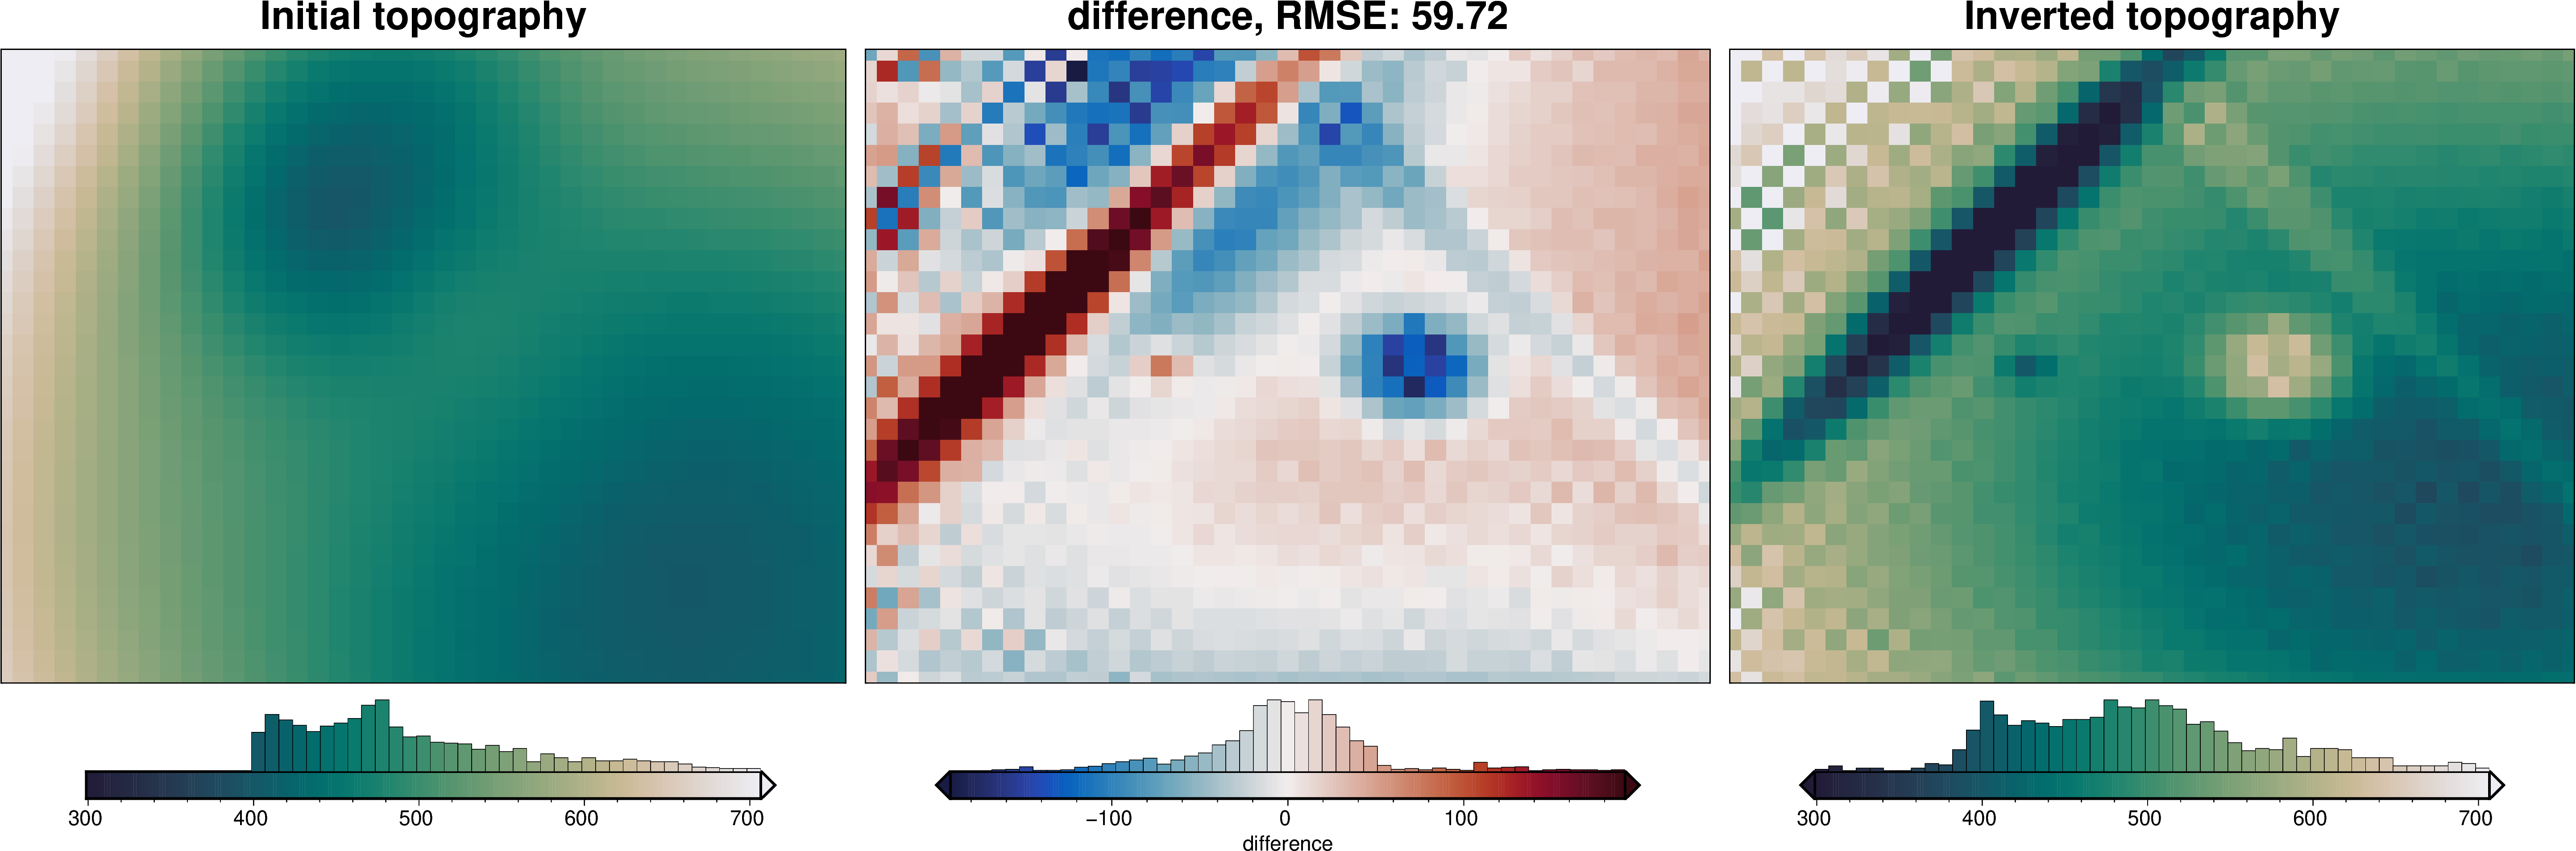

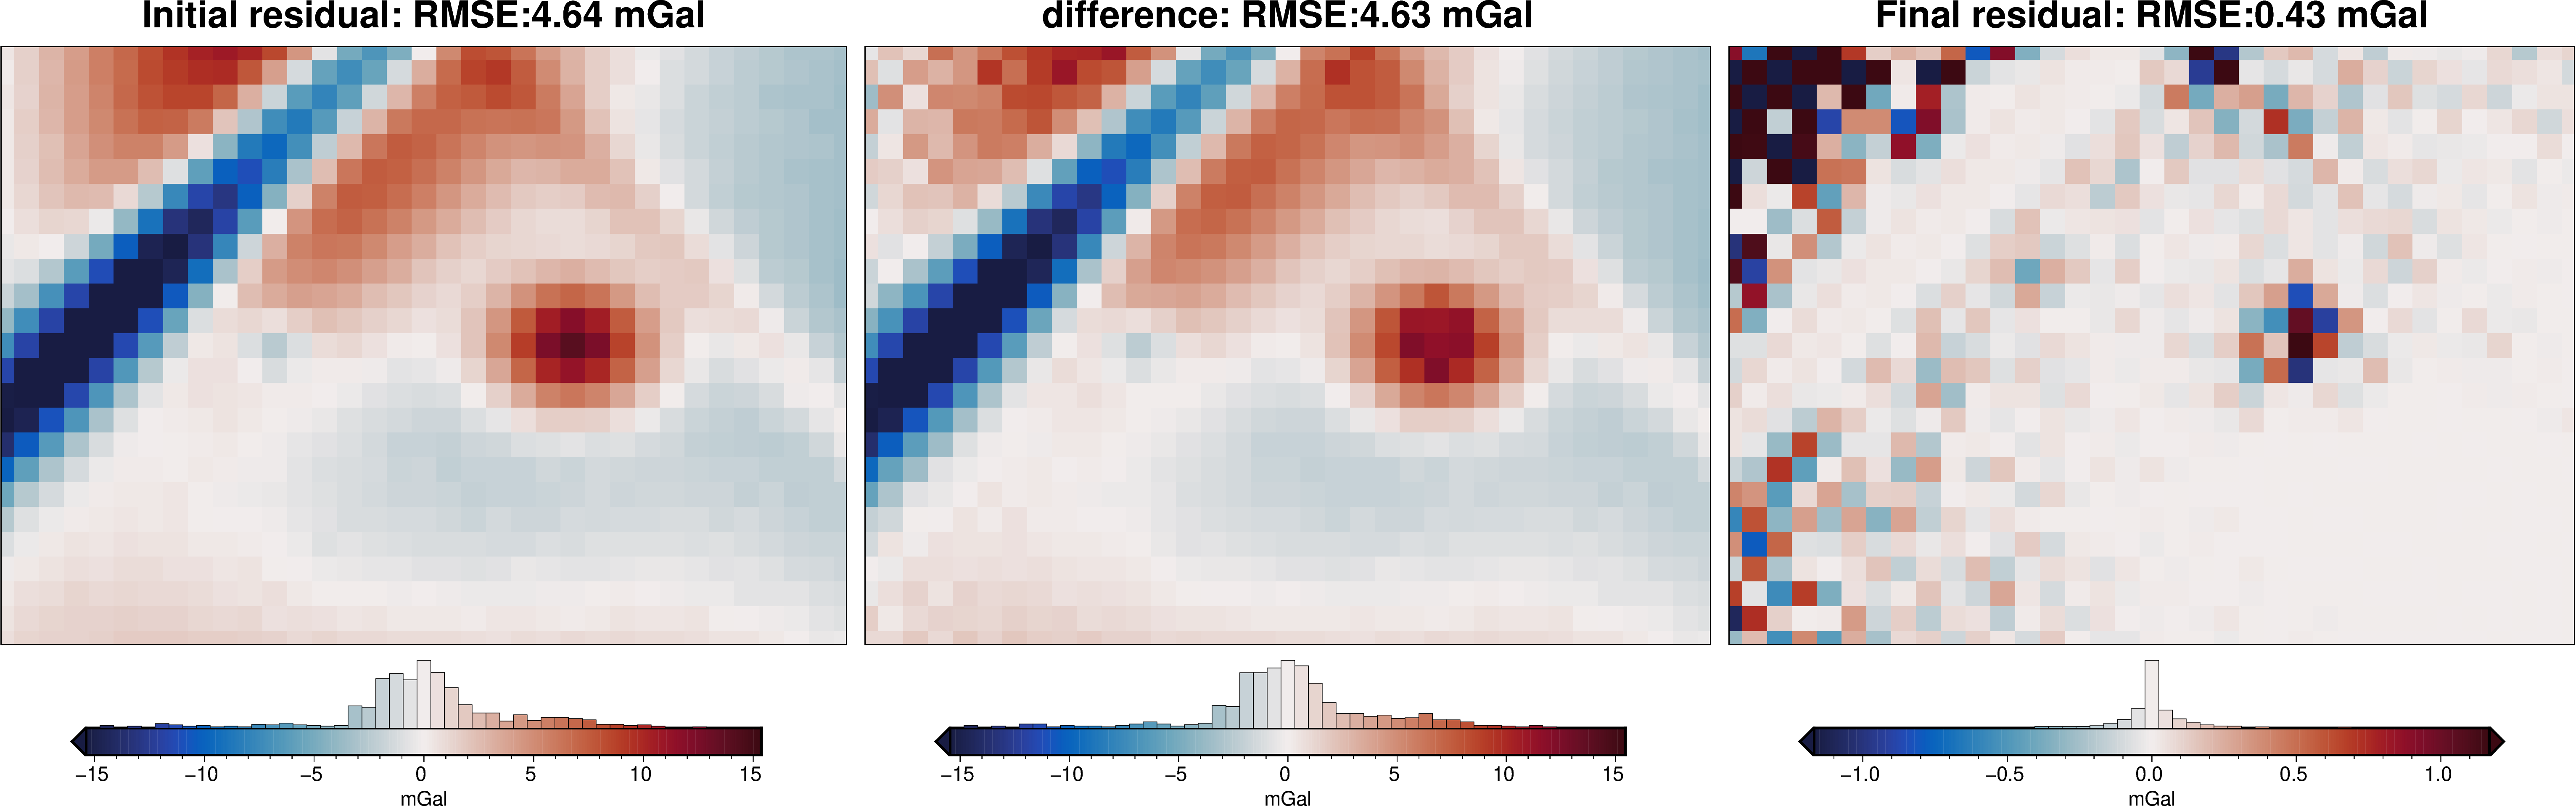

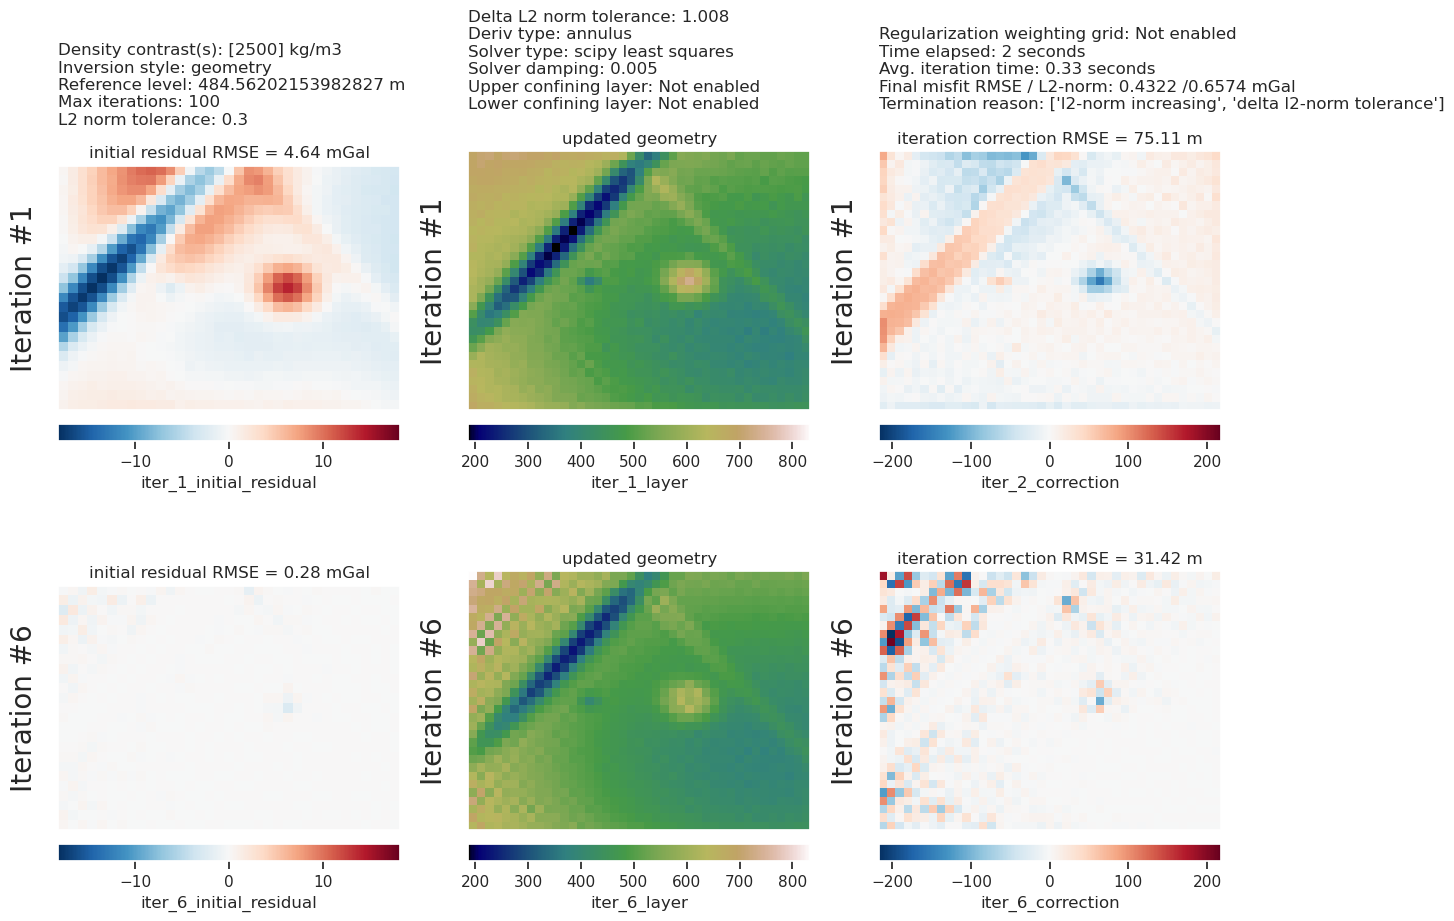

In [21]:
inv.plot_inversion_results(
    iters_to_plot=2,
)

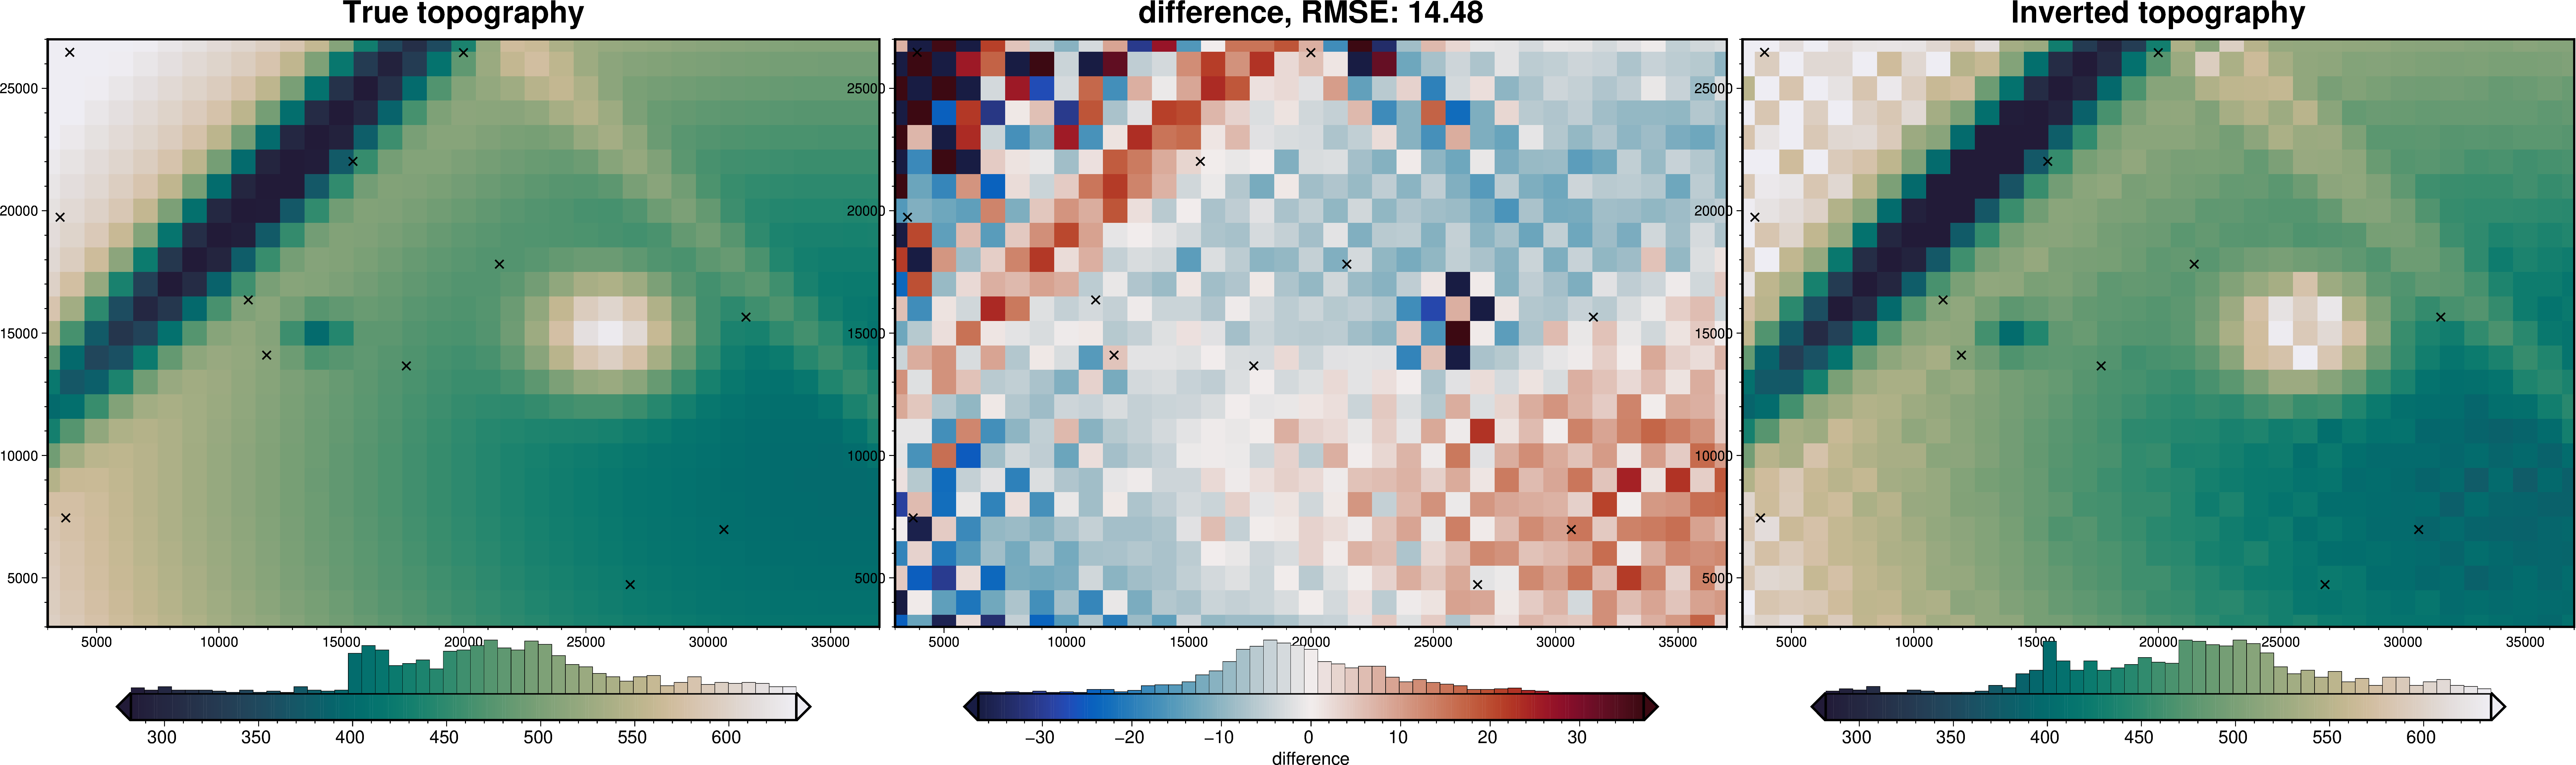

In [22]:
_ = ptk.grid_compare(
    true_topography,
    inv.model.topography,
    region=data.inner_region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    frame=True,
    points=constraint_points,
    points_style="x.3c",
)

## Damping parameter cross validation

### Resample to create testing / training data sets

In [23]:
data.inv.df

,northing,easting,upward,upper_surface_grav,lower_surface_grav,gravity_anomaly_no_noise,gravity_anomaly,uncert,forward_gravity,true_res,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
0,0.0,0.0,1001.0,9.525994,-0.047934,9.478060,9.494673,0.1,10.740517,-1.214524,-1.245844,-2.206417,0.960573,10.740517,-1.245844,-2.206417,0.960573
1,0.0,1000.0,1001.0,10.416800,-0.060607,10.356193,10.347023,0.1,11.470352,-1.053551,-1.123328,-2.237078,1.113750,11.470352,-1.123328,-2.237078,1.113750
2,0.0,2000.0,1001.0,9.945126,-0.079985,9.865141,9.933223,0.1,10.699837,-0.754711,-0.766613,-2.265336,1.498722,10.699837,-0.766613,-2.265336,1.498722
3,0.0,3000.0,1001.0,9.265122,-0.102636,9.162486,9.177017,0.1,9.740384,-0.475262,-0.563367,-2.291019,1.727652,9.740384,-0.563367,-2.291019,1.727652
4,0.0,4000.0,1001.0,8.528509,-0.126515,8.401994,8.352468,0.1,8.762056,-0.233547,-0.409588,-2.313984,1.904396,8.762056,-0.409588,-2.313984,1.904396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1001.0,3.330540,0.765378,4.095918,3.988219,0.1,5.931613,-2.601073,-1.943393,0.556564,-2.499957,5.931613,-1.943393,0.556564,-2.499957
1267,30000.0,37000.0,1001.0,3.328091,0.745878,4.073969,4.144597,0.1,6.177712,-2.849622,-2.033116,0.528422,-2.561537,6.177712,-2.033116,0.528422,-2.561537
1268,30000.0,38000.0,1001.0,3.333133,0.706587,4.039719,4.073005,0.1,6.390391,-3.057258,-2.317386,0.498959,-2.816345,6.390391,-2.317386,0.498959,-2.816345
1269,30000.0,39000.0,1001.0,3.298196,0.634280,3.932475,3.841945,0.1,6.478970,-3.180774,-2.637025,0.468525,-3.105550,6.478970,-2.637025,0.468525,-3.105550


In [24]:
inv.data.inv.df.columns

Index(['northing', 'easting', 'upward', 'upper_surface_grav',
       'lower_surface_grav', 'gravity_anomaly_no_noise', 'gravity_anomaly',
       'uncert', 'forward_gravity', 'true_res', 'misfit', 'reg', 'res',
       'starting_forward_gravity', 'starting_misfit', 'starting_reg',
       'starting_res', 'iter_1_initial_residual', 'iter_2_initial_residual',
       'iter_3_initial_residual', 'iter_4_initial_residual',
       'iter_5_initial_residual', 'iter_6_initial_residual'],
      dtype='object')

In [25]:
# resample data at 1/2 spacing to include test points for cross-validation
inv.data = invert4geom.add_test_points(inv.data)

In [26]:
inv.reinitialize_inversion()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0.022466102264381376

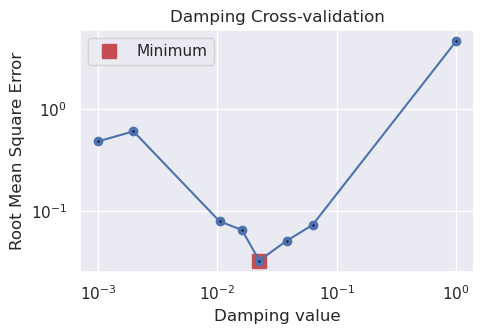

In [27]:
damping_cv_obj = inv.optimize_inversion_damping(
    damping_limits=(0.001, 1),
    n_trials=8,
    fname="../tmp/08_combining_it_all_damping_CV",
)
inv.solver_damping

In [28]:
damping_cv_obj.study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_damping,user_attrs_fname,system_attrs_fixed_params,state
0,0,0.483117,2026-02-08 11:55:33.581714,2026-02-08 11:55:34.582096,0 days 00:00:01.000382,0.001000,../tmp/08_combining_it_all_damping_CV_trial_0,{'damping': 0.001},COMPLETE
1,1,4.592577,2026-02-08 11:55:34.583011,2026-02-08 11:55:35.085093,0 days 00:00:00.502082,1.000000,../tmp/08_combining_it_all_damping_CV_trial_1,{'damping': 1},COMPLETE
2,2,0.606438,2026-02-08 11:55:35.085990,2026-02-08 11:55:36.421909,0 days 00:00:01.335919,0.001983,../tmp/08_combining_it_all_damping_CV_trial_2,NaN,COMPLETE
3,3,0.073751,2026-02-08 11:55:36.422928,2026-02-08 11:55:38.053792,0 days 00:00:01.630864,0.062714,../tmp/08_combining_it_all_damping_CV_trial_3,NaN,COMPLETE
4,4,0.033132,2026-02-08 11:55:38.063574,2026-02-08 11:55:38.925174,0 days 00:00:00.861600,0.022466,../tmp/08_combining_it_all_damping_CV_trial_4,NaN,COMPLETE
5,5,0.051643,2026-02-08 11:55:38.926227,2026-02-08 11:55:39.948970,0 days 00:00:01.022743,0.037996,../tmp/08_combining_it_all_damping_CV_trial_5,NaN,COMPLETE
6,6,0.080025,2026-02-08 11:55:39.950131,2026-02-08 11:55:41.099245,0 days 00:00:01.149114,0.010451,../tmp/08_combining_it_all_damping_CV_trial_6,NaN,COMPLETE
7,7,0.065959,2026-02-08 11:55:41.100322,2026-02-08 11:55:42.059566,0 days 00:00:00.959244,0.016082,../tmp/08_combining_it_all_damping_CV_trial_7,NaN,COMPLETE


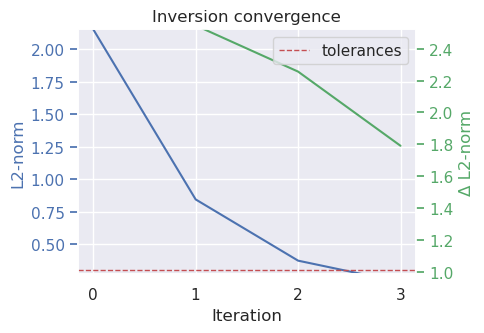

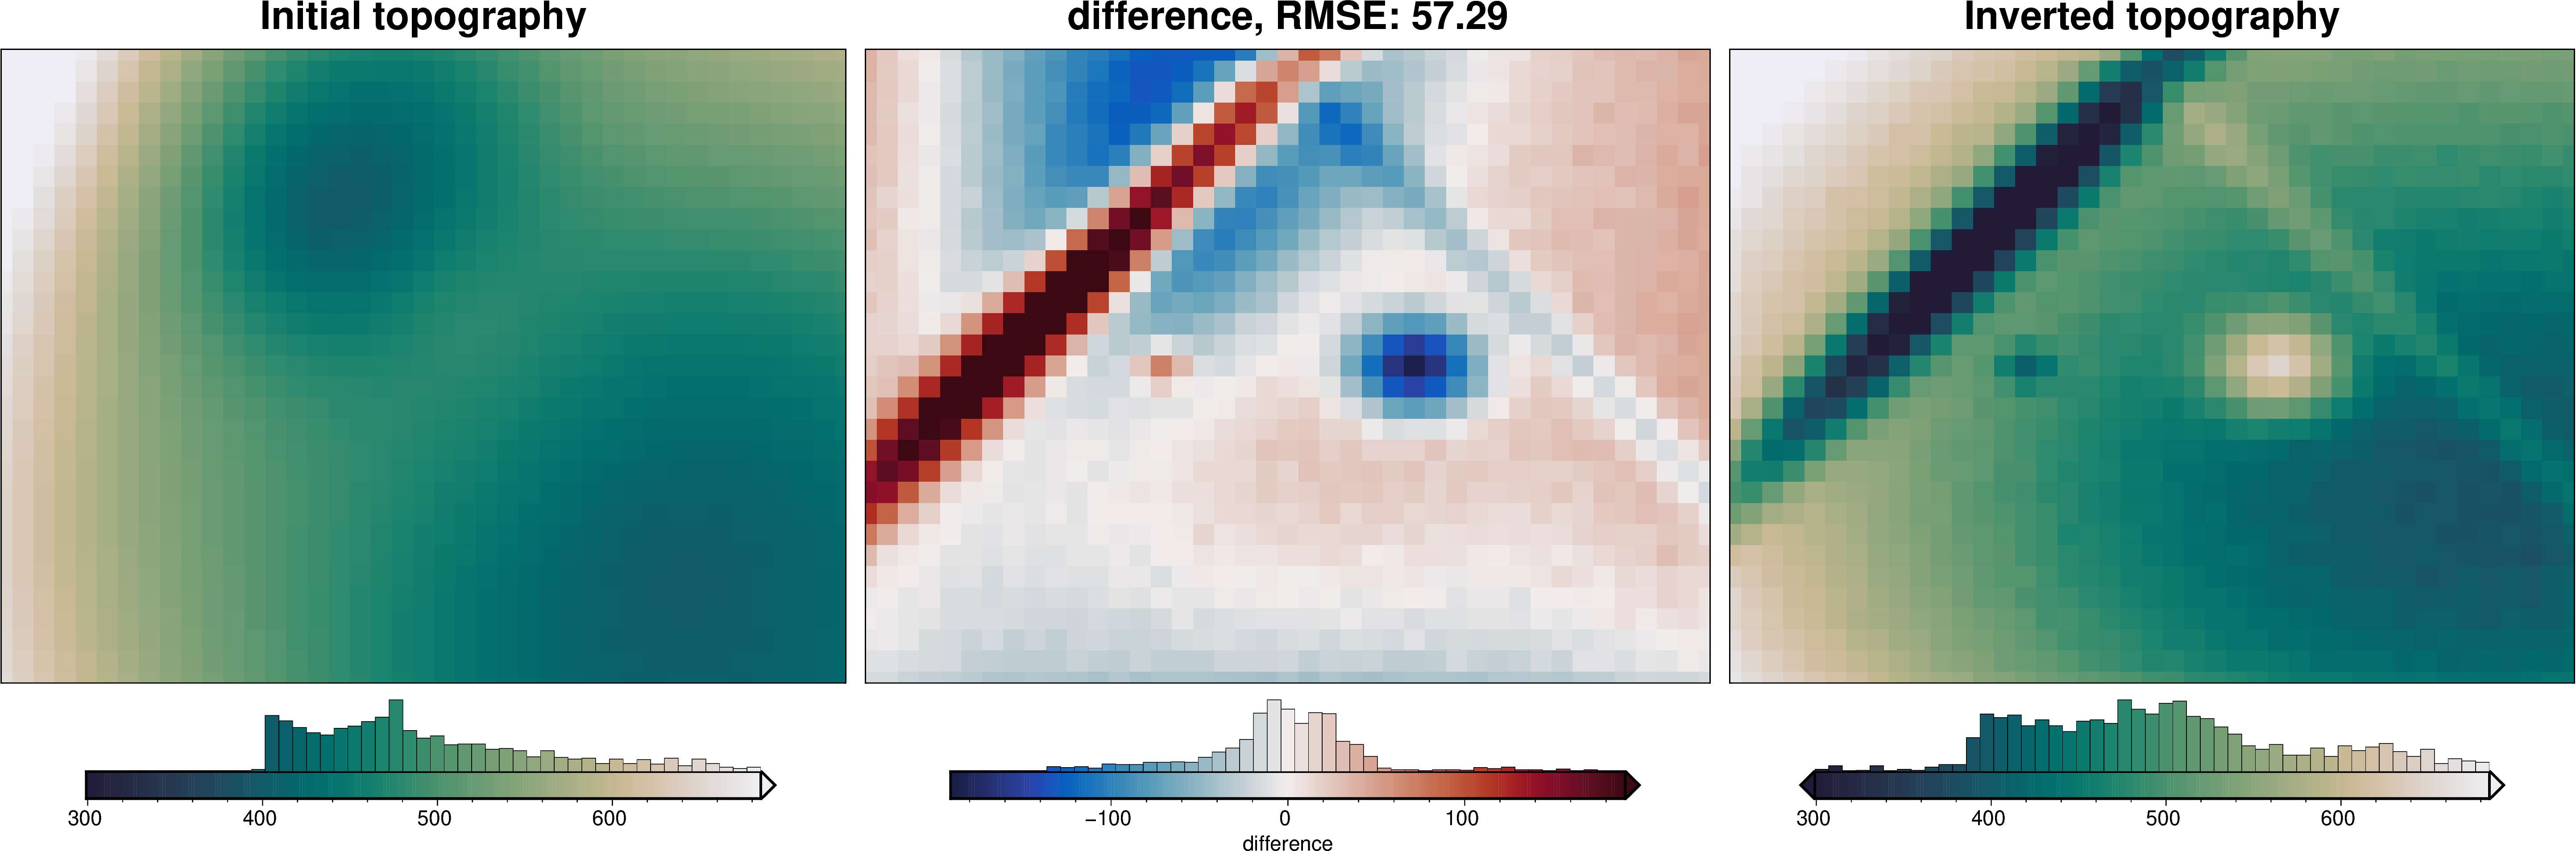

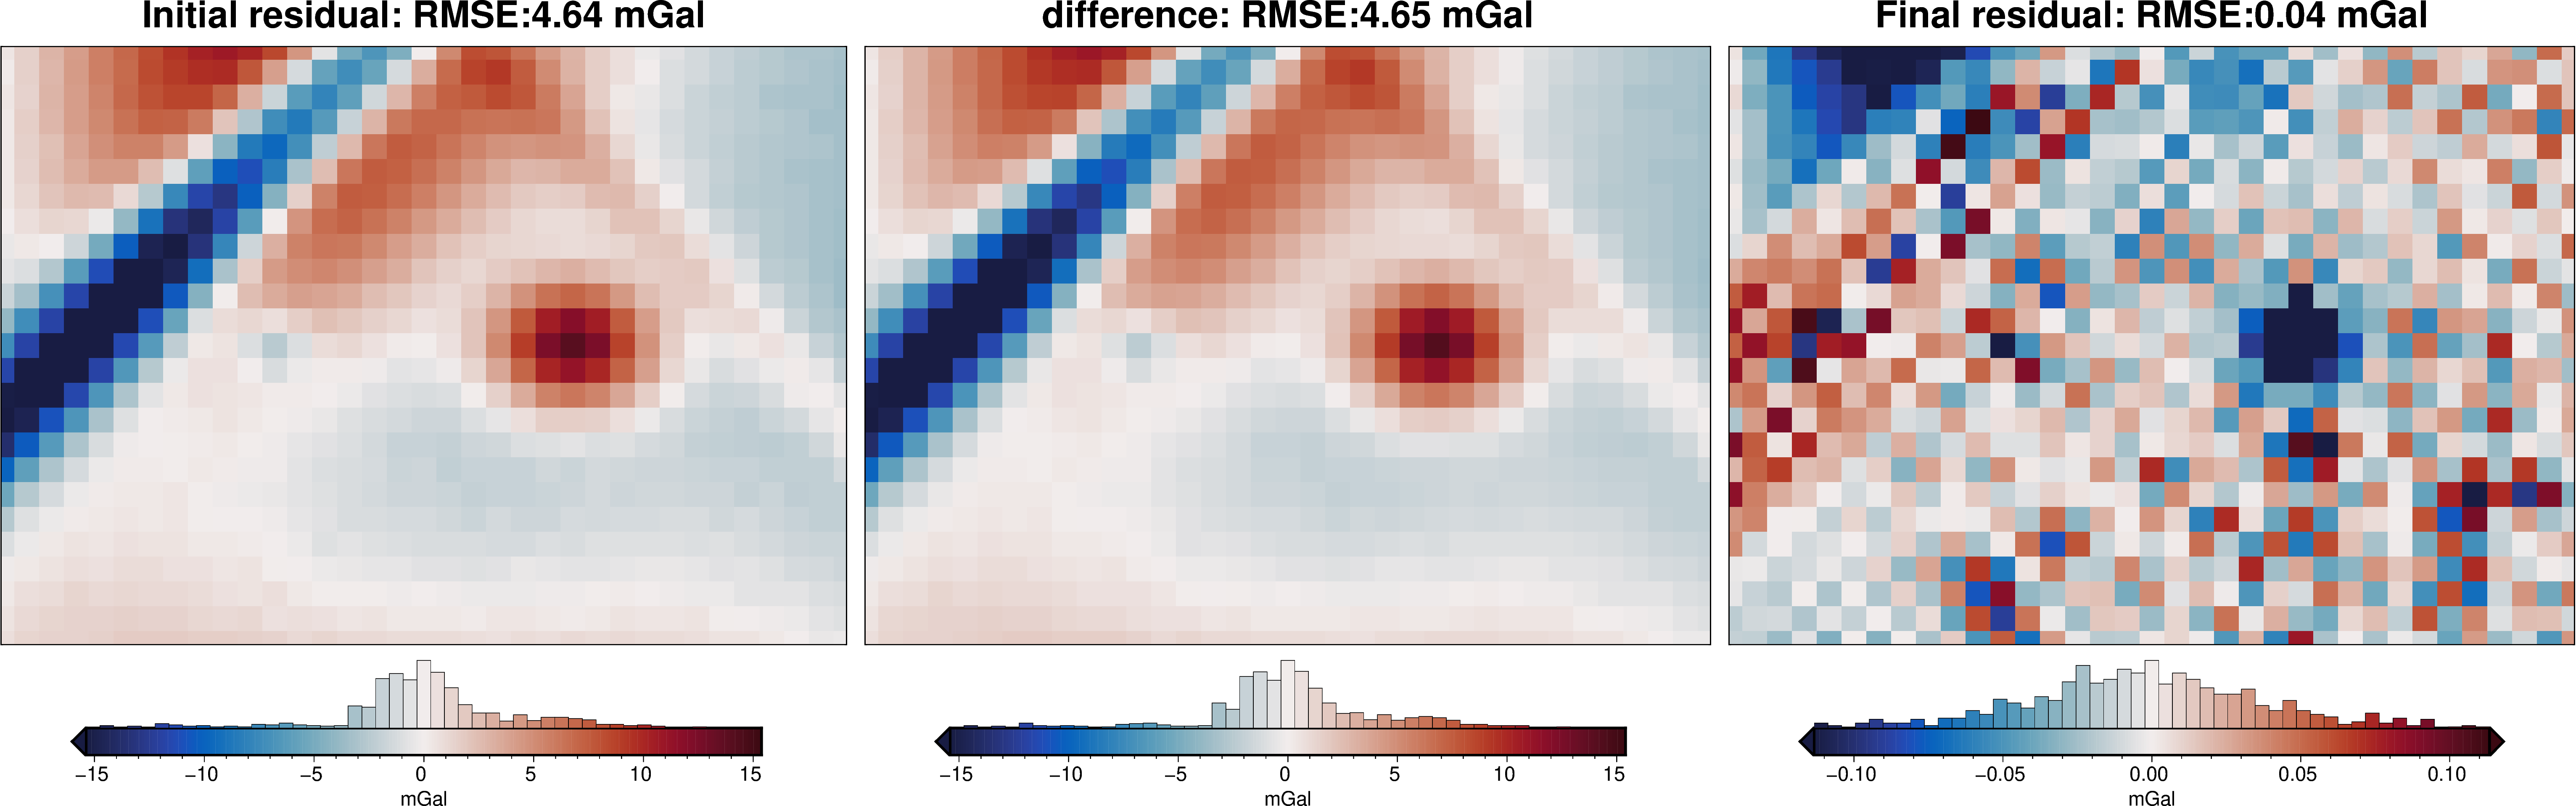

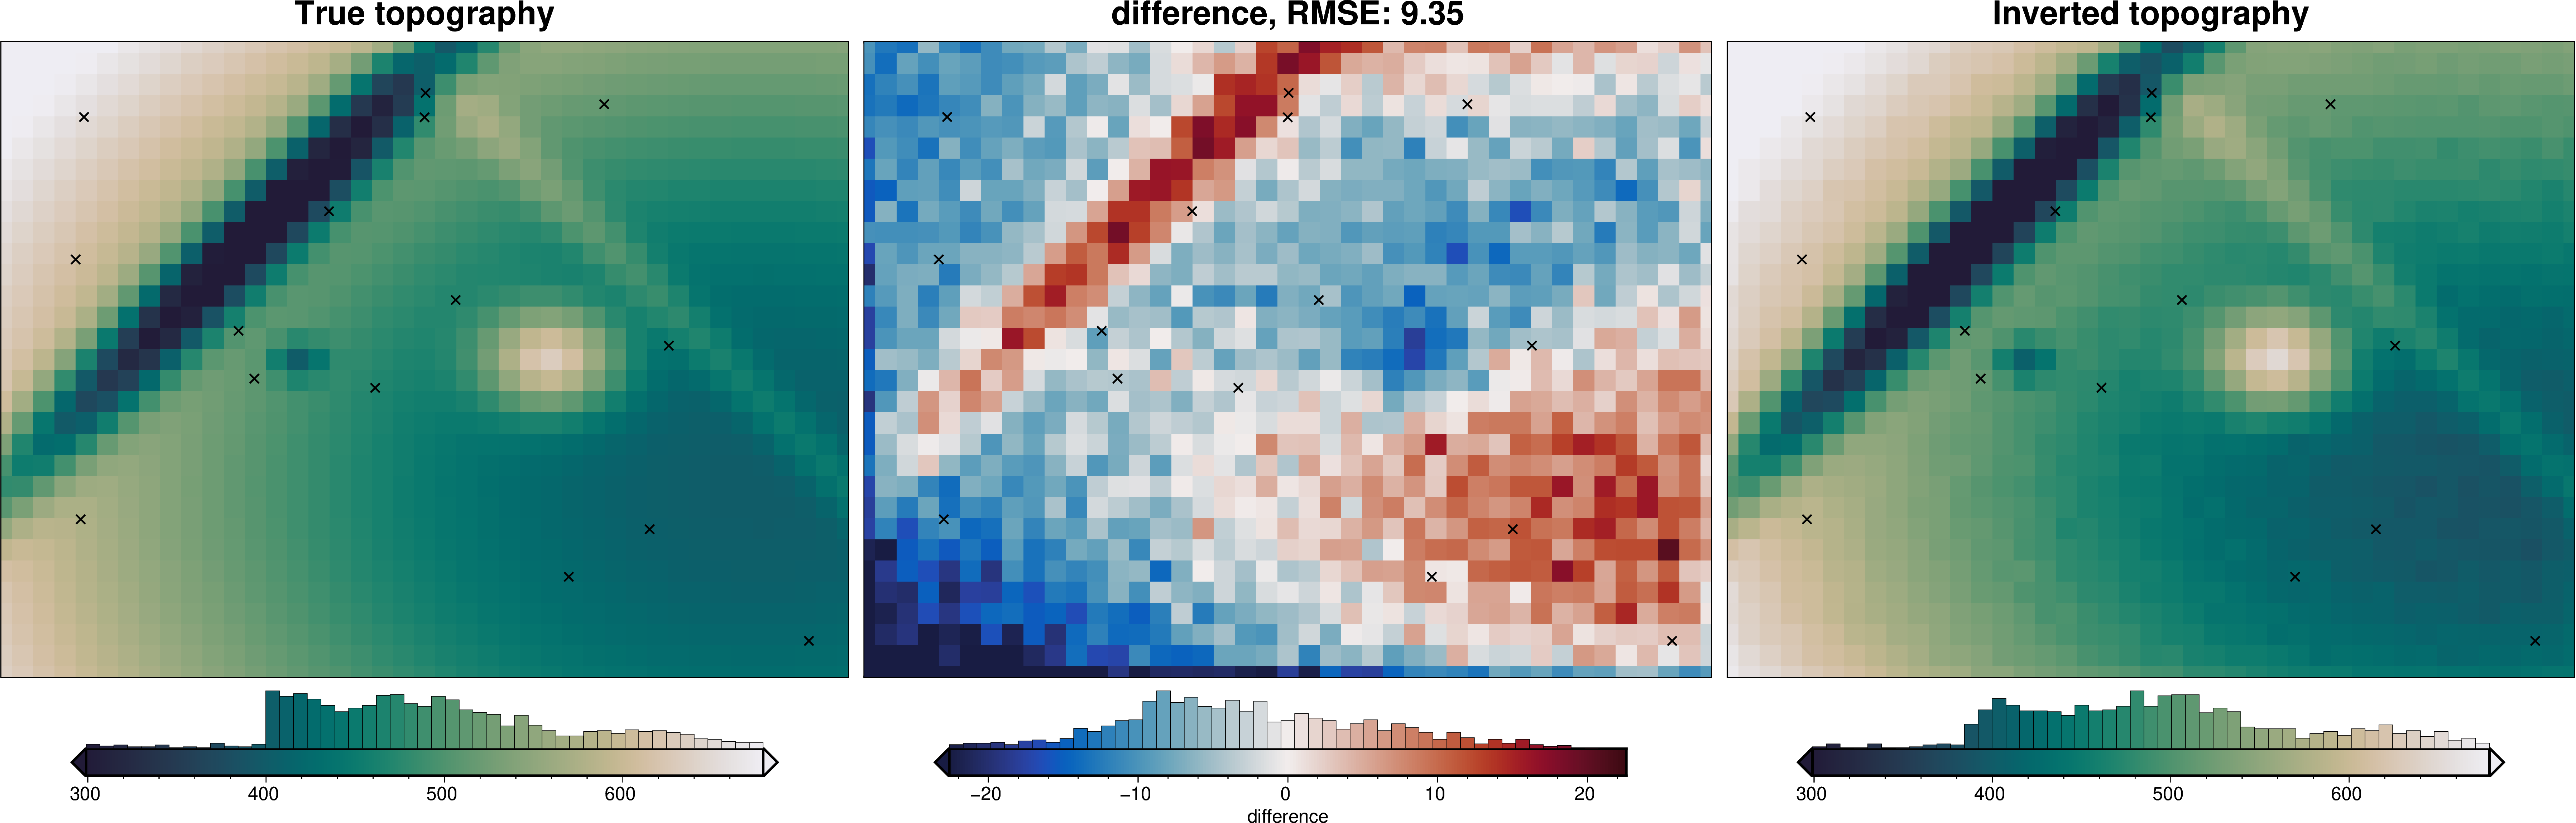

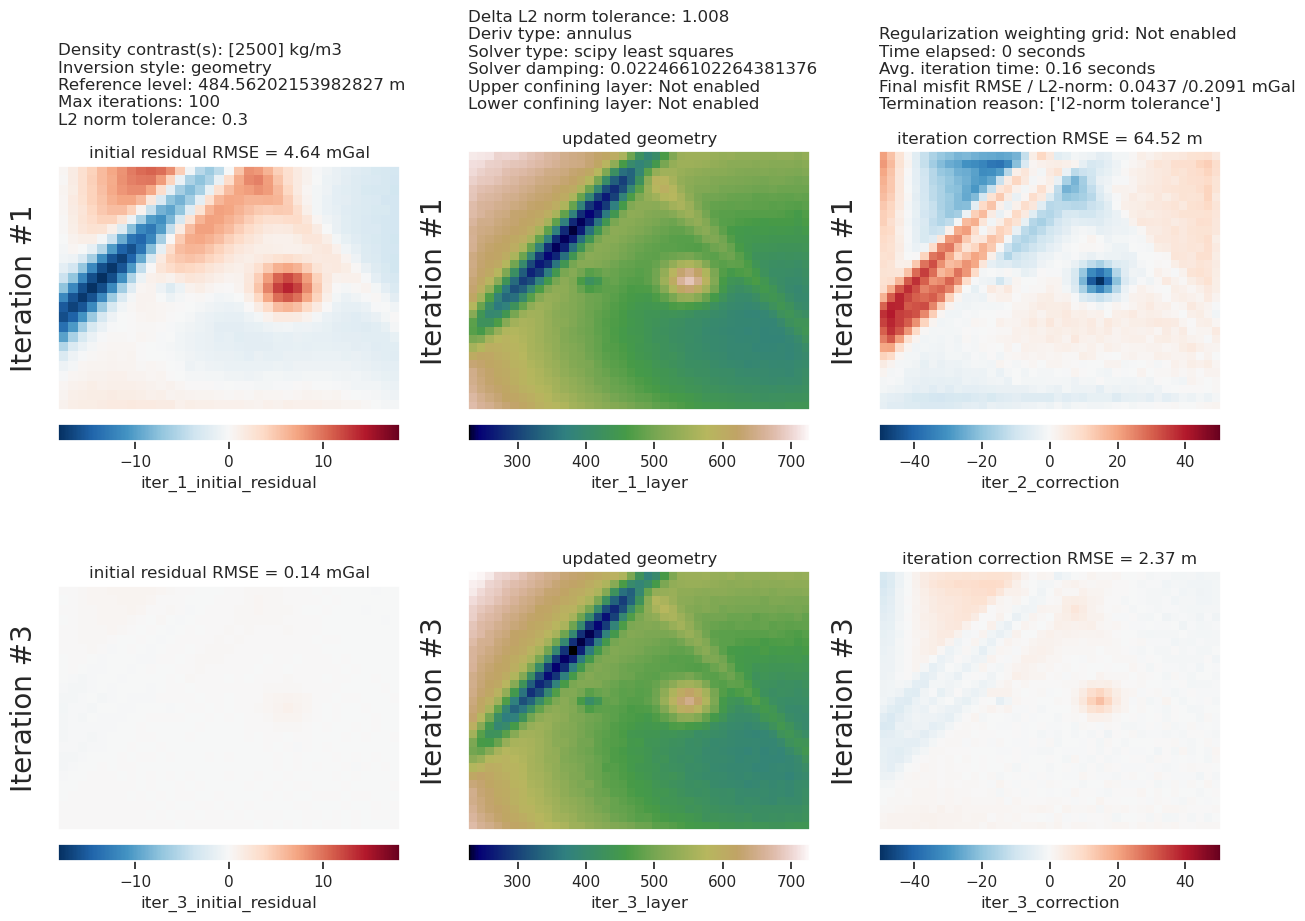

In [29]:
inv.plot_convergence()

inv.plot_inversion_results(iters_to_plot=2)

_ = ptk.grid_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [30]:
# sample the inverted topography at the constraint points
constraint_points = invert4geom.sample_grids(
    constraint_points,
    inv.model.topography,
    "inverted_topography",
)

rmse = invert4geom.rmse(
    constraint_points.upward - constraint_points.inverted_topography
)
print(f"RMSE: {rmse:.2f} m")

RMSE: 10.02 m


## Z-ref and density contrast optimizations
Since this optimization uses the inversion error at constraint points, we can't use the constraint point minimization technique to estimate the regional field since that inherently sets the inversion error at constraints to zero, invalidating the optimization scores. 

There are two options for how to get around this issue:
1) use a different regional estimation technique while finding the optimal density contrast and zref values, then use the found optimal values with the constraint point minimization regional estimation technique afterwards. 
2) use an internal cross-validation during the optimization by separating the constraints into testing and training sets, so that only the training set is used during the regional separation, and only the testing set is used for scoring during the density contrast and zref optimization. 

Well perform just the **first** method below. For the **second** method, see the [following notebook](09_combining_it_all_anternative_CV_technique.ipynb):

In [31]:
# we don't need the testing points anymore
inv.data = invert4geom.remove_test_points(inv.data)

In [32]:
inv.reinitialize_inversion()

In [33]:
# run the optimization for the zref and density
density_zref_optimization_obj = inv.optimize_inversion_zref_density_contrast(
    constraints_df=constraint_points,
    density_contrast_limits=(2300, 3000),
    zref_limits=(0, 1e3),
    n_trials=15,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    starting_topography=starting_topography,
    plot_scores=False,
    fname="../tmp/08_combining_it_all_density_and_zref_optimization",
)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


In [34]:
# to re-load the inv object from the saved pickle file
with pathlib.Path(
    "../tmp/08_combining_it_all_density_and_zref_optimization.pickle"
).open("rb") as f:
    inv = pickle.load(f)

# to re-load the study from the saved pickle file
with pathlib.Path(
    "../tmp/08_combining_it_all_density_and_zref_optimization_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

inv.solver_damping, inv.model.density_contrast, inv.model.zref

(0.022466102264381376, 2671, 487.68465298079485)

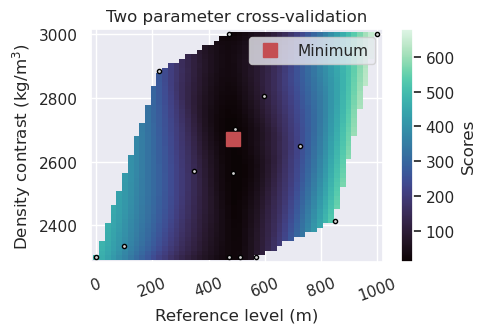

In [35]:
fig = invert4geom.plot_2_parameter_scores_uneven(
    study,
    param_names=(
        "params_zref",
        "params_density_contrast",
    ),
    plot_param_names=(
        "Reference level (m)",
        "Density contrast (kg/m$^3$)",
    ),
)

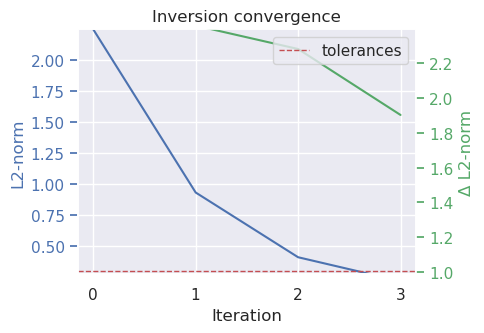

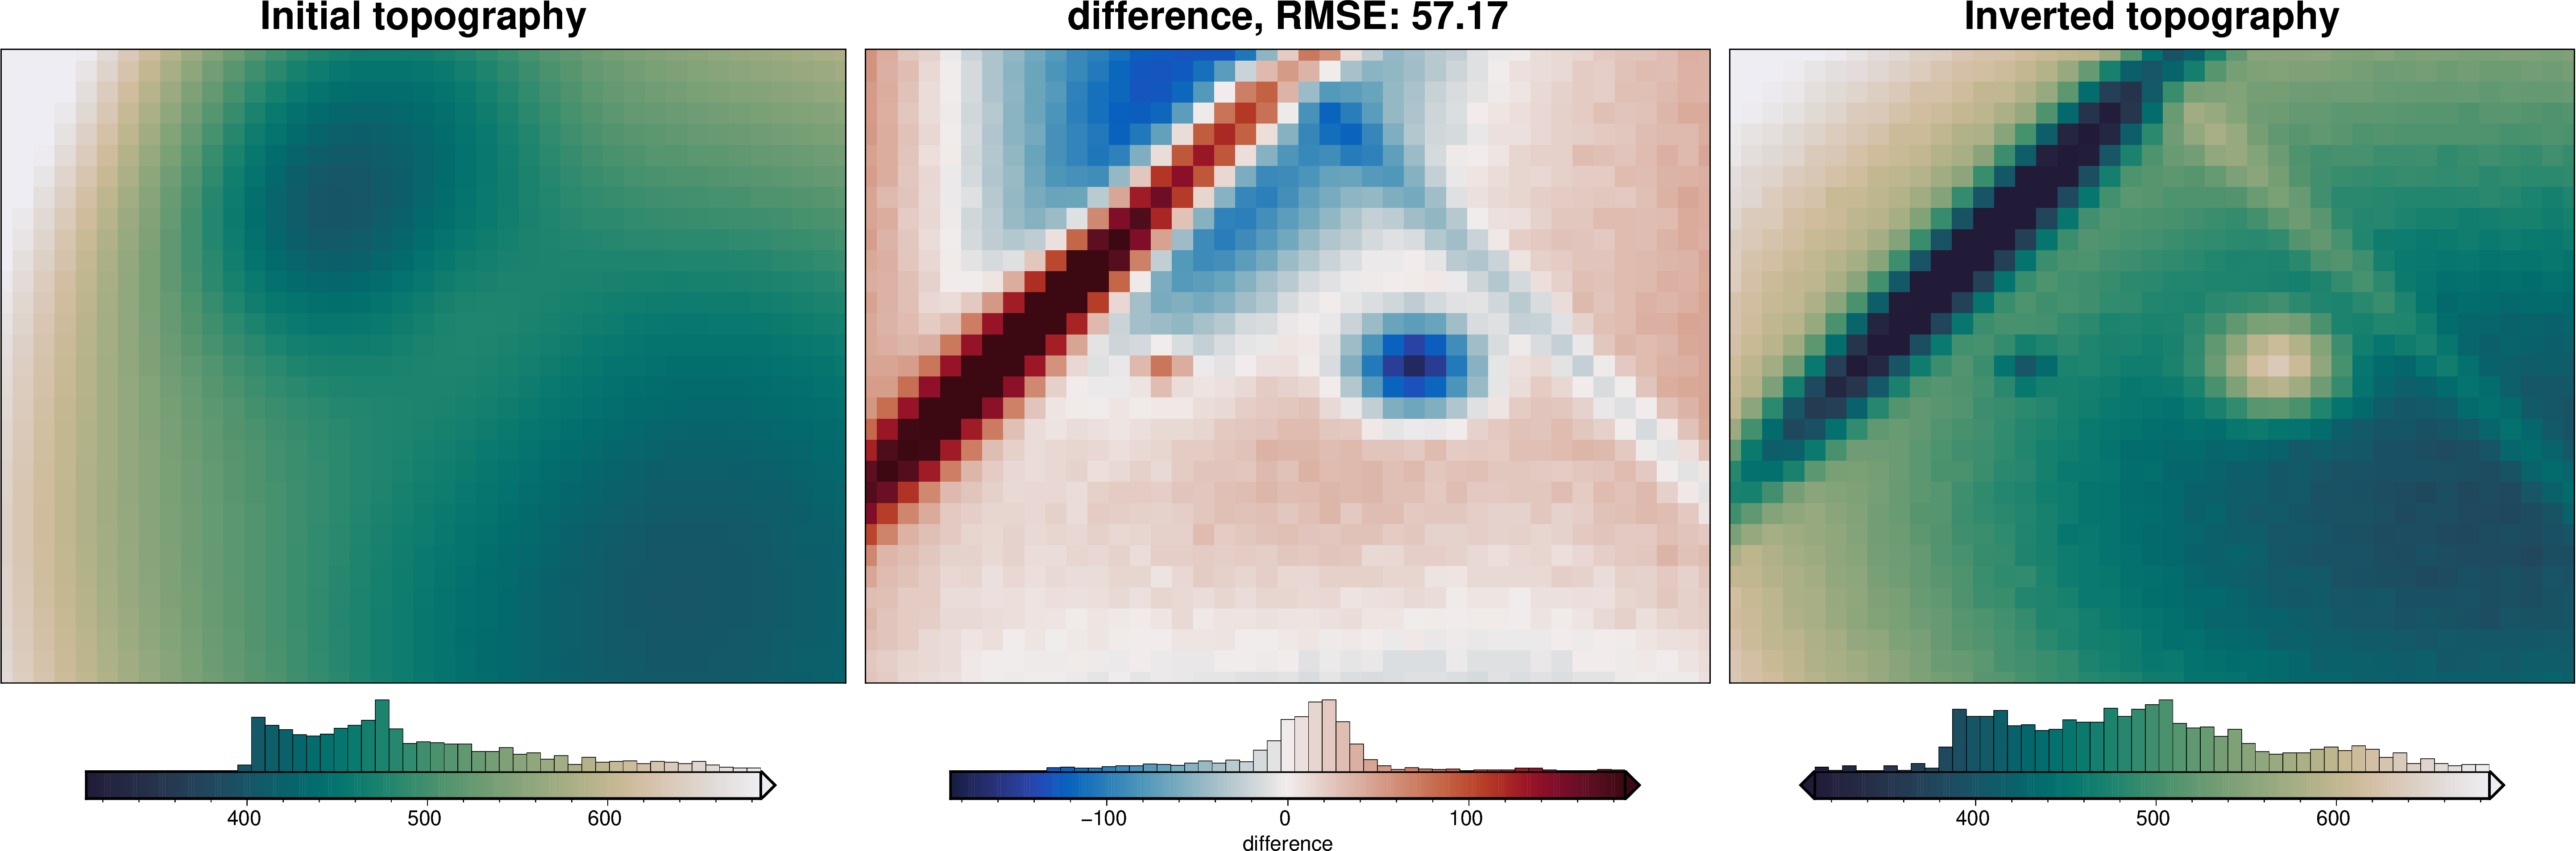

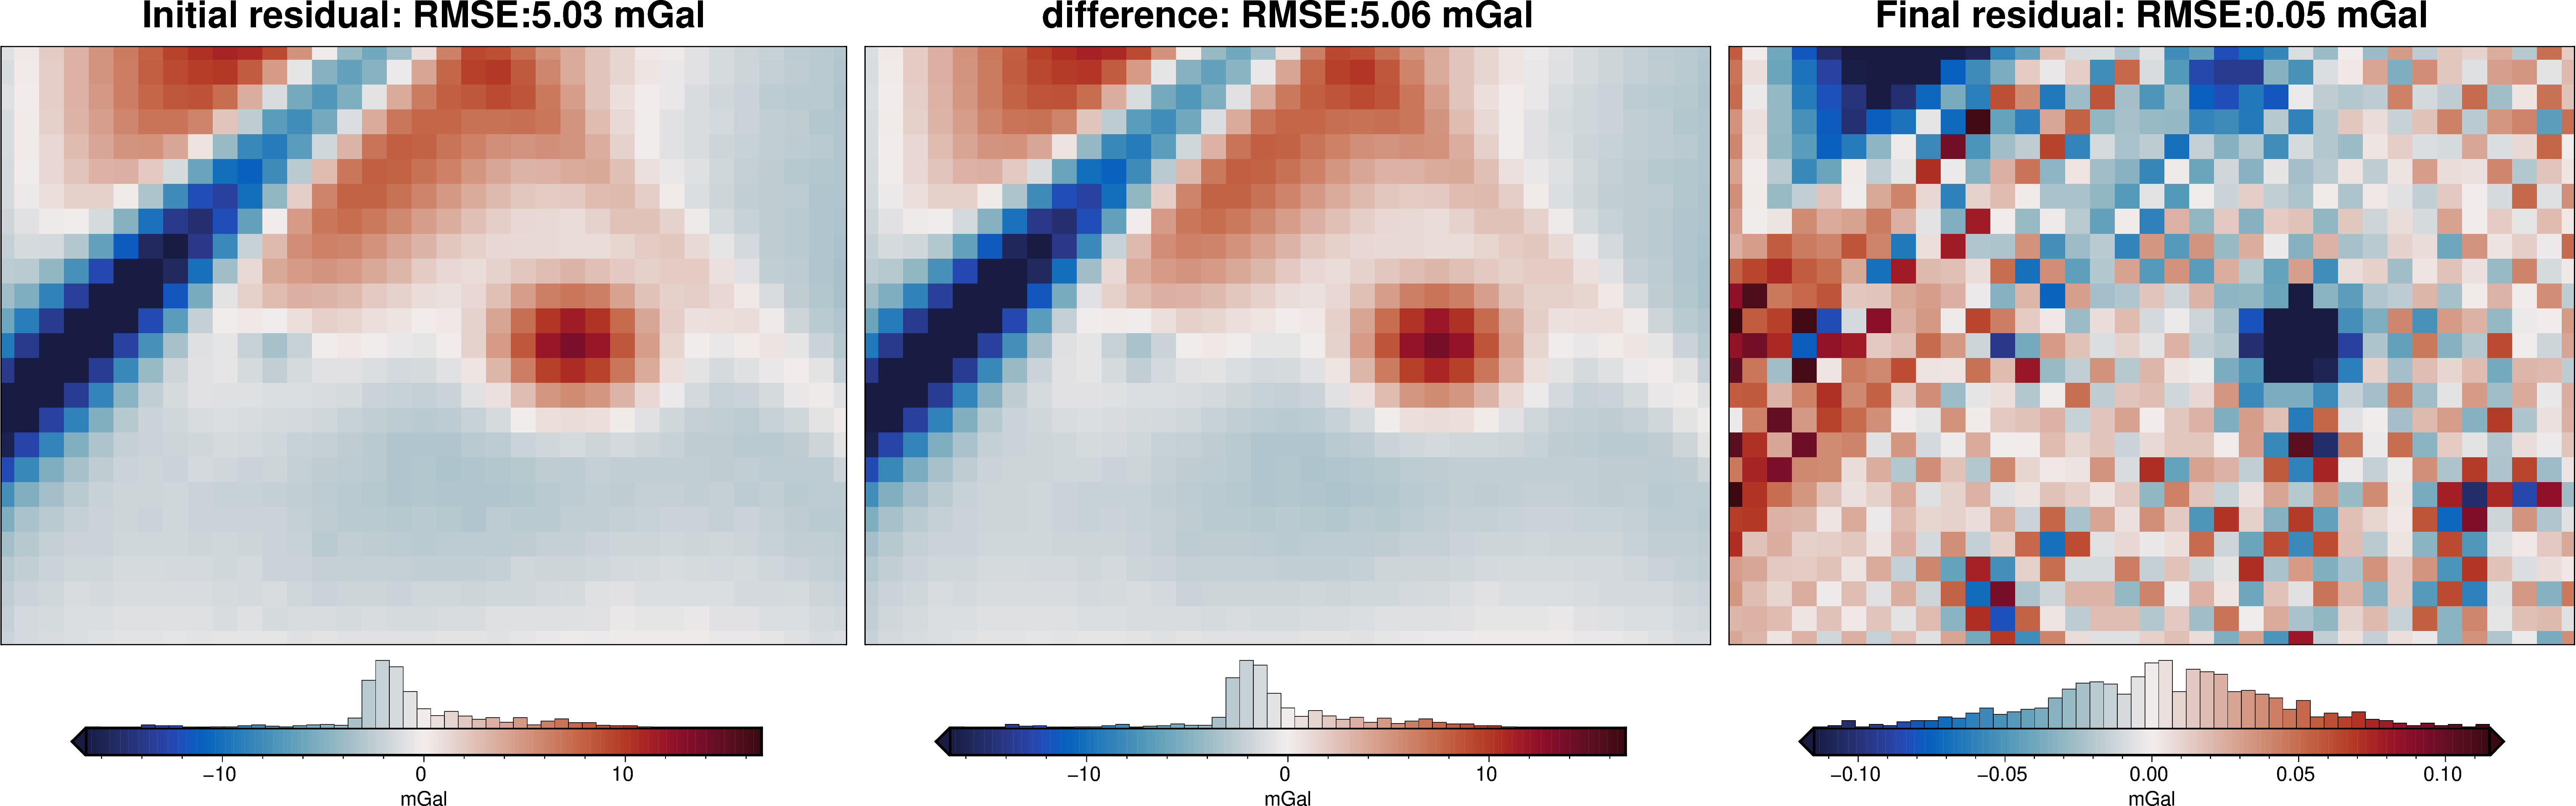

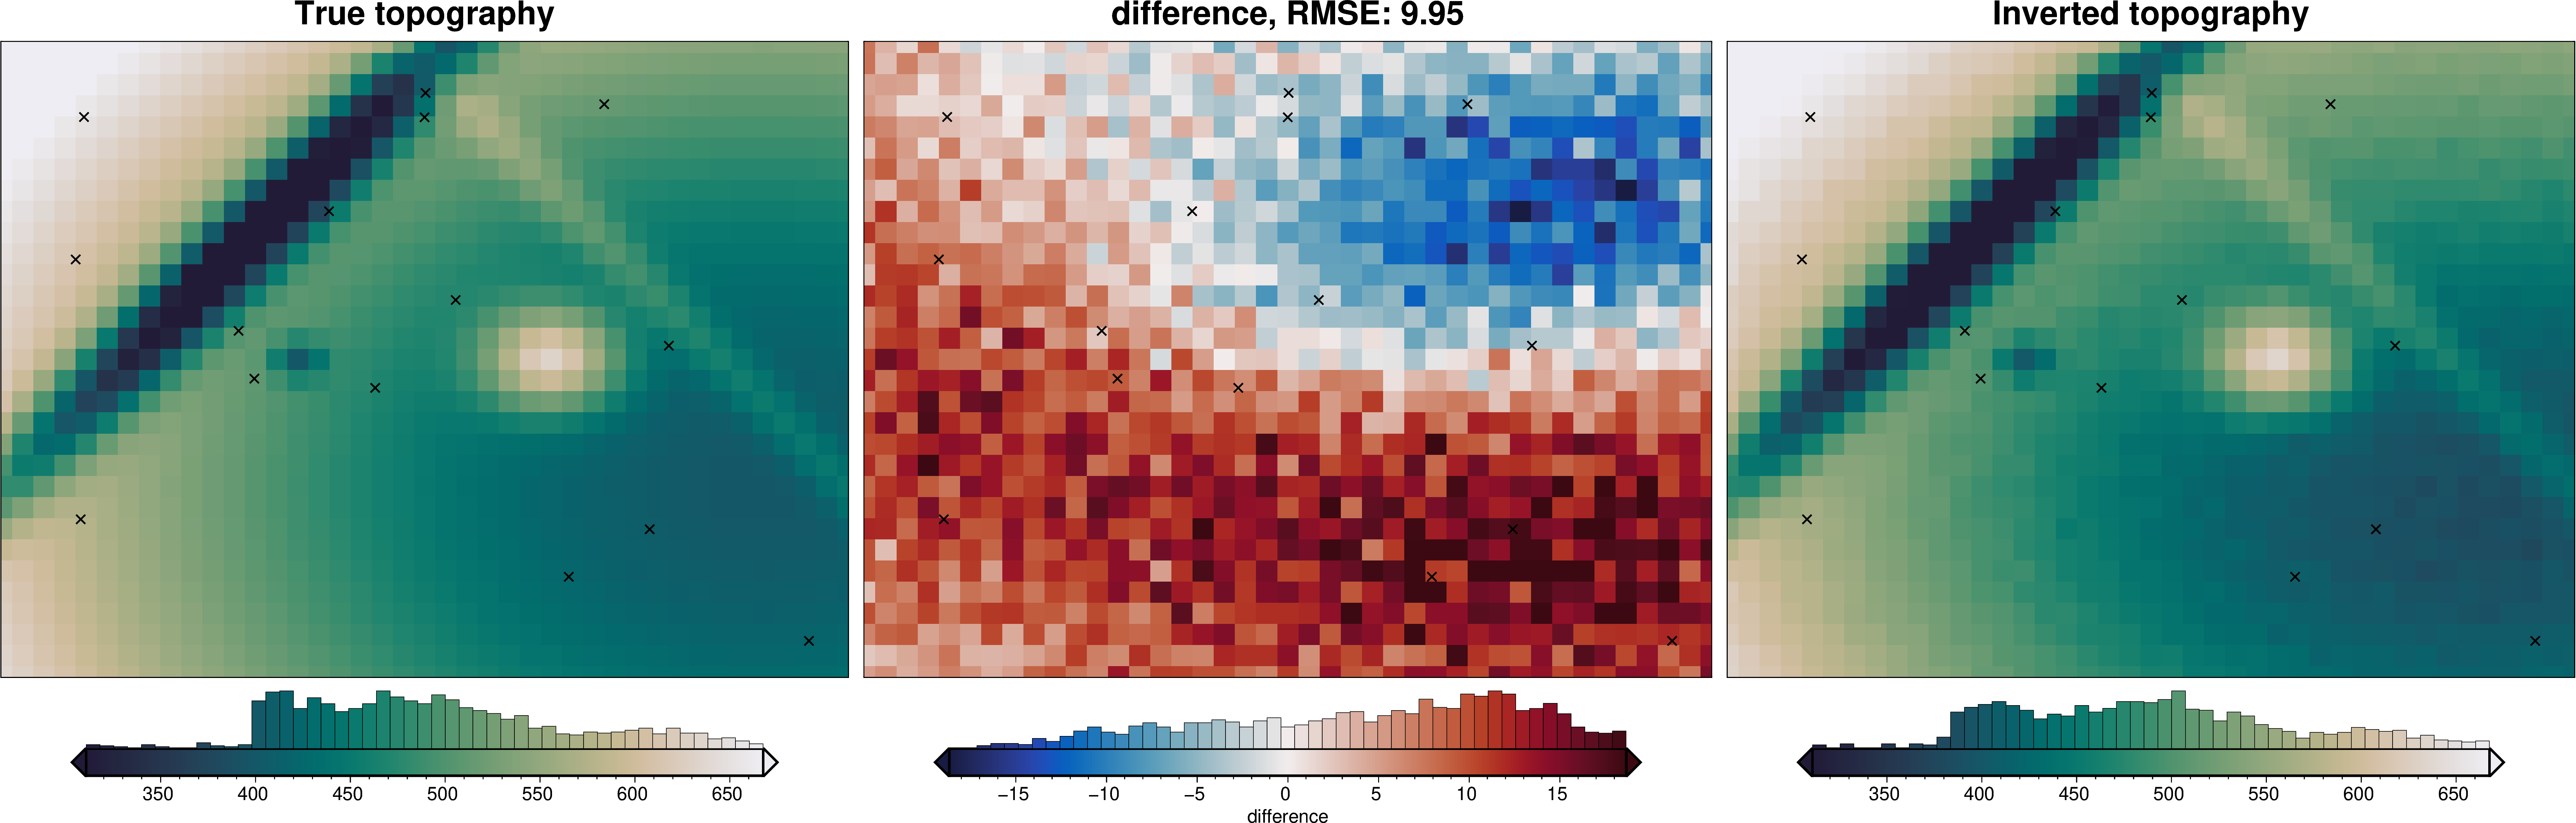

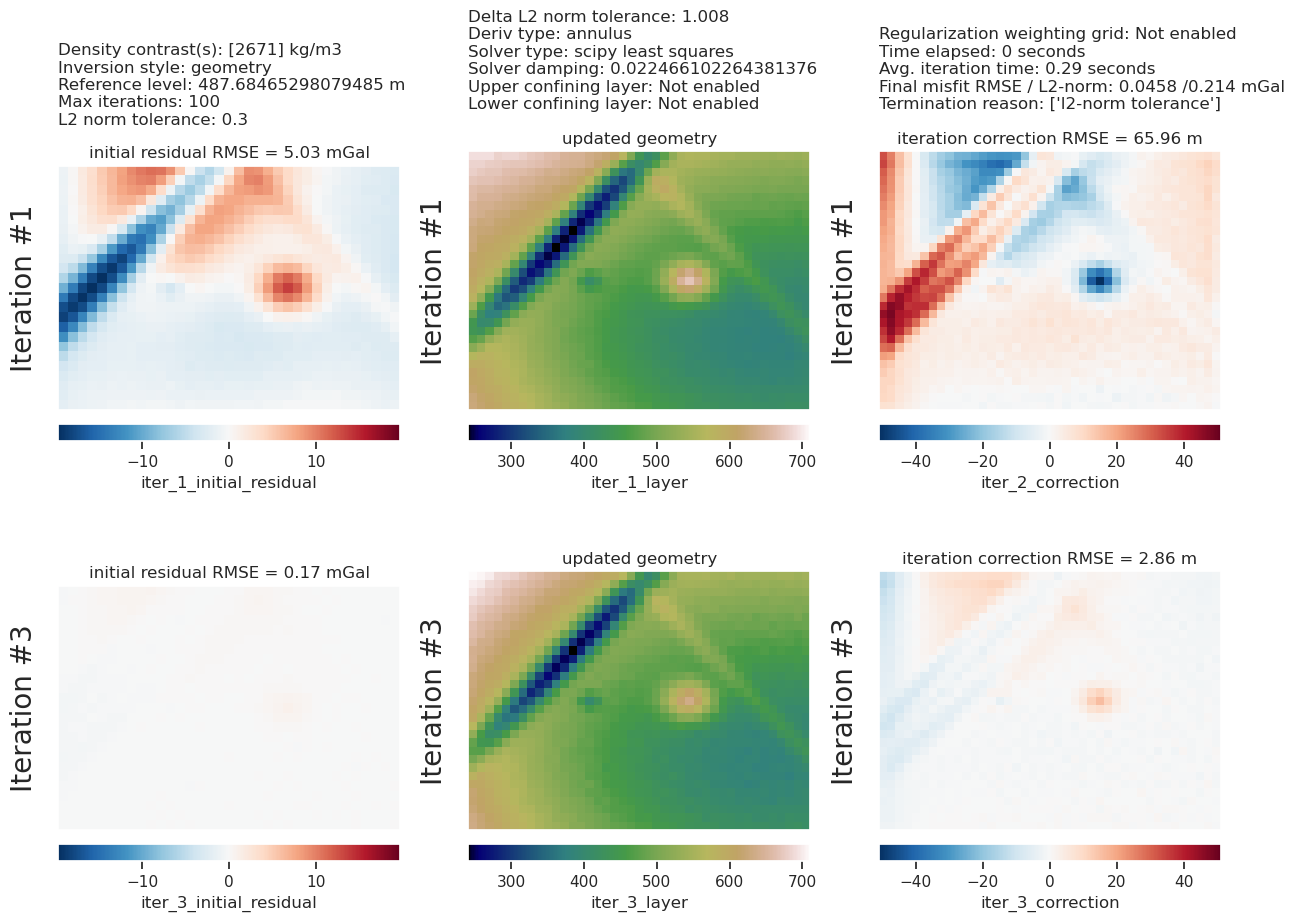

In [36]:
inv.plot_convergence()

inv.plot_inversion_results(iters_to_plot=2)

_ = ptk.grid_compare(
    true_topography,
    inv.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

## Save all data

We'll use the results from the first method of density constrast estimation since it performed better.

The notebook `Uncertainty analysis` will use all of the results from this notebook.

In [37]:
fname = "../tmp/08_combining_it_all_results.pickle"
pathlib.Path(fname).unlink(missing_ok=True)

with pathlib.Path(fname).open("ab") as file:
    pickle.dump(inv, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(regional_grav_kwargs, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(starting_topography_kwargs, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(true_topography, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(constraint_points, file, protocol=pickle.HIGHEST_PROTOCOL)